# Load in model

In [2]:
import torch
import numpy as npd
from torch.utils.data import DataLoader
from datasets import Dataset, load_dataset
from tqdm.auto import tqdm
from functools import partial
from einops import rearrange
from huggingface_hub import hf_hub_download
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification
from baukit import TraceDict

# Download the model
device = "cuda:0"
model_name="EleutherAI/Pythia-70M-deduped"
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)
# set seed
torch.manual_seed(0)
np.random.seed(0)

/root/logan/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load in Sparse AE's

In [3]:
from autoencoders import *
# ae_model_id = ["jbrinkma/Pythia-70M-chess_sp51_r4_gpt_neox.layers.1", "jbrinkma/Pythia-70M-chess_sp51_r4_gpt_neox.layers.2.mlp"]
model_id = "jbrinkma/Pythia-70M-deduped-SAEs"
autoencoders = []
layers = model.config.num_hidden_layers
cache_names = [(f"gpt_neox.layers.{i}", f"gpt_neox.layers.{i+1}.mlp") for i in range(layers-1)]
# cache_names = [(f"gpt_neox.layers.{i}", f"gpt_neox.layers.{i+1}.attention") for i in range(layers-1)]
# cache_names = [(f"gpt_neox.layers.{i}", f"gpt_neox.layers.{i+1}.mlp") for i in range(1,2)]
num_layers = len(cache_names)
cache_names = [item for sublist in cache_names for item in sublist]
filenames = [(f"Pythia-70M-deduped-{i}.pt", f"Pythia-70M-deduped-mlp-{i+1}.pt") for i in range(layers-1)]
# filenames = [(f"Pythia-70M-deduped-{i}.pt", f"Pythia-70M-deduped-attention-{i+1}.pt") for i in range(layers-1)]
# filenames = [(f"Pythia-70M-deduped-{i}.pt", f"Pythia-70M-deduped-mlp-{i+1}.pt") for i in range(1,2)]
filenames = [item for sublist in filenames for item in sublist]
for filen in filenames:
    ae_download_location = hf_hub_download(repo_id=model_id, filename=filen)
    autoencoder = torch.load(ae_download_location)
    autoencoder.to_device(device)
    # Freeze autoencoder weights
    autoencoder.encoder.requires_grad_(False)
    autoencoder.encoder_bias.requires_grad_(False)
    autoencoders.append(autoencoder)

# Load training data

In [4]:
from activation_dataset import setup_token_data
from utils import dotdict

# Download the dataset
# This formats it, so every datapoint is max_length tokens long
# The batch size is for loading activations from the LLM, not for inference on the autoencoder
cfg = dotdict()
cfg.dataset_name="stas/openwebtext-10k"
cfg.max_length = 256
cfg.model_batch_size = 4
dataset = setup_token_data(cfg, tokenizer, model)
num_tokens = cfg.max_length*cfg.model_batch_size*len(dataset)
print(f"Number of tokens: {num_tokens}")
num_features, d_model = autoencoder.encoder.shape

Found cached dataset openwebtext-10k (/root/.cache/huggingface/datasets/stas___openwebtext-10k/plain_text/1.0.0/3a8df094c671b4cb63ed0b41f40fb3bd855e9ce2e3765e5df50abcdfb5ec144b)
Loading cached processed dataset at /root/.cache/huggingface/datasets/stas___openwebtext-10k/plain_text/1.0.0/3a8df094c671b4cb63ed0b41f40fb3bd855e9ce2e3765e5df50abcdfb5ec144b/cache-89f7d956ed9de0f6_*_of_00008.arrow


Number of tokens: 11226112


## Model Definitions

In [5]:
from torch.optim import Adam
from torch import nn
class sparse_two_nonlinear(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size)
        self.linear2 = nn.Linear(input_size, input_size)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        return x
    
class mlp(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size)
        self.linear2 = nn.Linear(input_size, input_size)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x
    
class mlp_no_bias(nn.Module):
    def __init__(self, input_size, output_size=None):
        super().__init__()
        if(output_size is None):
            output_size = input_size
        self.linear = nn.Linear(input_size, input_size, bias=False)
        self.linear2 = nn.Linear(input_size, output_size, bias=False)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear(x)
        x_hidden = self.relu(x)
        x = self.linear2(x_hidden)
        return x
    
class sae(nn.Module):
    def __init__(self, input_size, output_size=None):
        super().__init__()
        if(output_size is None):
            output_size = input_size
        self.linear = nn.Linear(input_size, input_size, bias=False)
        self.linear2 = nn.Linear(input_size, output_size, bias=False)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear(x)
        x_hidden = self.relu(x)
        x = self.linear2(x_hidden)
        return x, x_hidden
    
class sparse_nonlinear(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        return x

    
class sparse_nonlinear_no_bias(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size, bias=False)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        return x

class linear(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size)
    def forward(self, x):
        x = self.linear(x)
        return x

class linear_no_bias(nn.Module):
    def __init__(self, input_size, output_size=None):
        super().__init__()
        if(output_size is None):
            output_size = input_size
        self.linear = nn.Linear(input_size, output_size, bias=False)
    def forward(self, x):
        x = self.linear(x)
        return x

## Find Dead Features in Output layers

In [6]:

total_batches = 500
feature_activations = torch.zeros((num_layers, num_features))
norms = torch.zeros((num_layers))
norms_input = torch.zeros((num_layers))
with torch.no_grad():
    for i, batch in enumerate(tqdm(dataset)):
        batch = batch["input_ids"].to(device)

        # Grab intermediate activations in ret
        with TraceDict(model, cache_names) as ret:
            _ = model(batch)
    
        for cache_name_ind in range(num_layers):
            #Only find dead features in output layer. This will effect MSE the most
            output_cache_name = cache_names[cache_name_ind * 2 + 1]
            input_cache_name = cache_names[cache_name_ind * 2]
            output_autoencoder = autoencoders[cache_name_ind * 2 + 1]
            input_autoencoder = autoencoders[cache_name_ind * 2]
            output_activations = ret[output_cache_name].output
            input_activations = ret[input_cache_name].output
            if isinstance(output_activations, tuple):
                output_activations = output_activations[0]
            if isinstance(input_activations, tuple):
                input_activations = input_activations[0]
            output_internal_activations = rearrange(output_activations , "b s n -> (b s) n")
            input_internal_activations = rearrange(input_activations , "b s n -> (b s) n")

            norms[cache_name_ind] += output_internal_activations.norm(dim=1).mean().cpu()
            norms_input[cache_name_ind] += input_internal_activations.norm(dim=1).mean().cpu()

            #Now we have internal activations, run through autoencoder
            output_internal_activations = output_autoencoder.encode(output_internal_activations)
            
            feature_activations[cache_name_ind] += output_internal_activations.sum(dim=0).cpu()
        if i > total_batches:
            break
    alive_features_ind = (feature_activations != 0)
    alive_features_ind = alive_features_ind
    norms = norms/total_batches
    norms_input = norms_input/total_batches
normalization_per_layer = (norms/norms.min())**2
normalization_per_layer_input = (norms_input/norms_input.min())**2
print(f"Norms: {norms}")
print(f"Alive features: {alive_features_ind.sum(dim=1)} / {num_features}")
print(f"Norms input: {norms_input}")

  5%|▍         | 501/10963 [00:17<06:13, 28.02it/s]


Norms: tensor([ 4.2548,  6.8740,  9.6674, 13.1338, 54.1928])
Alive features: tensor([1081,  772, 1319, 1606,  804]) / 3072
Norms input: tensor([ 7.1562,  9.0303, 13.1627, 15.0991, 16.4075])


In [11]:
# Save the normalization per layer
torch.save(normalization_per_layer, "normalization_per_layer.pt")

In [6]:
initialize_weights = False
two_nonlinear_weights = []
mlp_weights = []
nonlinear_weights = []
linear_weights = []
mlp_weights_no_bias = []
nonlinear_weights_no_bias = []
linear_weights_no_bias = []

two_nonlinear_optimizers = []
mlp_optimizers = []
nonlinear_optimizers = []
linear_optimizers = []
mlp_optimizers_no_bias = []
nonlinear_optimizers_no_bias = []
linear_optimizers_no_bias = []
for auto_ind in range(len(autoencoders)//2):
    two_nonlinear_weights.append(sparse_two_nonlinear(num_features))
    two_nonlinear_weights[-1].to(device)
    two_nonlinear_optimizers.append(Adam(two_nonlinear_weights[-1].parameters(), lr=1e-3))

    mlp_weights.append(mlp(num_features))
    mlp_weights[-1].to(device)
    mlp_optimizers.append(Adam(mlp_weights[-1].parameters(), lr=1e-3))

    mlp_weights_no_bias.append(mlp_no_bias(num_features))
    mlp_weights_no_bias[-1].to(device)
    mlp_optimizers_no_bias.append(Adam(mlp_weights_no_bias[-1].parameters(), lr=1e-3))

    nonlinear_weights.append(sparse_nonlinear(num_features))
    nonlinear_weights[-1].to(device)
    nonlinear_optimizers.append(Adam(nonlinear_weights[-1].parameters(), lr=1e-3))

    nonlinear_weights_no_bias.append(sparse_nonlinear_no_bias(num_features))
    nonlinear_weights_no_bias[-1].to(device)
    nonlinear_optimizers_no_bias.append(Adam(nonlinear_weights_no_bias[-1].parameters(), lr=1e-3))

    linear_weights.append(linear(num_features))
    linear_weights[-1].to(device)
    linear_optimizers.append(Adam(linear_weights[-1].parameters(), lr=1e-3))

    linear_weights_no_bias.append(linear_no_bias(num_features))
    linear_weights_no_bias[-1].to(device)
    linear_optimizers_no_bias.append(Adam(linear_weights_no_bias[-1].parameters(), lr=1e-3))

    if(initialize_weights): #Note this doesn't work,
        # Multiply the decoder weights by mlp weights & second autoencoder's encoder weights
        decoder = autoencoders[auto_ind].encoder
        mlp_enc = model.gpt_neox.layers[auto_ind+1].mlp.dense_h_to_4h.weight.detach().T
        mlp_dec = model.gpt_neox.layers[auto_ind+1].mlp.dense_4h_to_h.weight.detach().T
        encoder = autoencoders[auto_ind+1].encoder.T
        initial_weights = decoder @ mlp_enc @ mlp_dec @ encoder
        nonlinear_weights[-1].linear.weight.data = initial_weights
        linear_weights[-1].linear.weight.data = initial_weights

## Train the model

In [7]:

def train_sparse_model(model, dataset, device, sparse_weights, autoencoders, cache_names, optimizers):
    mse = nn.MSELoss()
    l1_alpha = 1e-3
    batch_size = 32
    losses = [[] for _ in range(len(sparse_weights))]
    
    # with dataset.formatted_as("pt"):
    #     dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for i, batch in enumerate(tqdm(dataset)):
        batch = batch["input_ids"].to(device)
        with torch.no_grad():
            with TraceDict(model, cache_names) as ret:
                _ = model(batch)
        
        for cache_name_ind in range(len(cache_names) // 2):
            sparse_weight = sparse_weights[cache_name_ind]

            input_cache_name = cache_names[cache_name_ind * 2]
            output_cache_name = cache_names[cache_name_ind * 2 + 1]
            input_autoencoder = autoencoders[cache_name_ind * 2]
            output_autoencoder = autoencoders[cache_name_ind * 2 + 1]
            input_activations = ret[input_cache_name].output
            output_activations = ret[output_cache_name].output

            if isinstance(input_activations, tuple):
                input_activations = input_activations[0]
            if isinstance(output_activations, tuple):
                output_activations = output_activations[0]

            input_internal_activations = rearrange(input_activations, "b s n -> (b s) n")
            output_internal_activations = rearrange(output_activations, "b s n -> (b s) n")

            input_internal_activations = input_autoencoder.encode(input_internal_activations)
            output_internal_activations = output_autoencoder.encode(output_internal_activations)

            x_hat = sparse_weights[cache_name_ind](input_internal_activations)

            # loss = mse(x_hat, output_internal_activations)
            current_alive_features_ind = alive_features_ind[cache_name_ind].nonzero(as_tuple=True)[0]
            indexed_x_hat = x_hat.index_select(dim=1, index=current_alive_features_ind.to(device))
            indexed_output_internal_activations = output_internal_activations.index_select(dim=1, index=current_alive_features_ind.to(device))
            loss = mse(indexed_x_hat, indexed_output_internal_activations)
            l1_loss = torch.norm(sparse_weight.linear.weight, dim=1, p=1).mean()
            # loss += l1_alpha * l1_loss

            loss.backward()
            optimizers[cache_name_ind].step()
            optimizers[cache_name_ind].zero_grad()
            losses[cache_name_ind].append(loss.item())

            if i % 100 == 0:
                print(f"Layers: {cache_name_ind} | MSE Loss: {loss.item()} | L1 Loss: {l1_loss.item()}")
            
        if i > 3000:
            # Stop training after 1000 batches
            break
    return losses
# two_nonlinear_losses = train_sparse_model(model, dataset, device, two_nonlinear_weights, autoencoders, cache_names, two_nonlinear_optimizers)
# mlp_losses = train_sparse_model(model, dataset, device, mlp_weights, autoencoders, cache_names, mlp_optimizers)

# nonlinear_losses = train_sparse_model(model, dataset, device, nonlinear_weights, autoencoders, cache_names, nonlinear_optimizers)
# linear_losses = train_sparse_model(model, dataset, device, linear_weights, autoencoders, cache_names, linear_optimizers)

mlp_losses_no_bias = train_sparse_model(model, dataset, device, mlp_weights_no_bias, autoencoders, cache_names, mlp_optimizers_no_bias)
# nonlinear_losses_no_bias = train_sparse_model(model, dataset, device, nonlinear_weights_no_bias, autoencoders, cache_names, nonlinear_optimizers_no_bias)
linear_losses_no_bias = train_sparse_model(model, dataset, device, linear_weights_no_bias, autoencoders, cache_names, linear_optimizers_no_bias)

  0%|          | 1/10963 [00:00<1:09:41,  2.62it/s]

Layers: 0 | MSE Loss: 0.004682254046201706 | L1 Loss: 27.711380004882812
Layers: 1 | MSE Loss: 0.0631730780005455 | L1 Loss: 27.709020614624023
Layers: 2 | MSE Loss: 0.022445719689130783 | L1 Loss: 27.70949363708496
Layers: 3 | MSE Loss: 0.050982192158699036 | L1 Loss: 27.71640396118164
Layers: 4 | MSE Loss: 3.5823211669921875 | L1 Loss: 27.71370506286621


  1%|          | 101/10963 [00:16<29:11,  6.20it/s]

Layers: 0 | MSE Loss: 0.0015500730369240046 | L1 Loss: 30.09900665283203
Layers: 1 | MSE Loss: 0.005024129990488291 | L1 Loss: 36.23994445800781
Layers: 2 | MSE Loss: 0.004429538734257221 | L1 Loss: 33.71697235107422
Layers: 3 | MSE Loss: 0.006564100738614798 | L1 Loss: 34.33531188964844
Layers: 4 | MSE Loss: 0.13930489122867584 | L1 Loss: 46.20189666748047


  2%|▏         | 201/10963 [00:32<29:32,  6.07it/s]

Layers: 0 | MSE Loss: 0.0011387290433049202 | L1 Loss: 32.761566162109375
Layers: 1 | MSE Loss: 0.0046332902275025845 | L1 Loss: 39.204505920410156
Layers: 2 | MSE Loss: 0.003546703839674592 | L1 Loss: 37.348052978515625
Layers: 3 | MSE Loss: 0.004387363791465759 | L1 Loss: 38.82490158081055
Layers: 4 | MSE Loss: 0.05345650762319565 | L1 Loss: 47.310340881347656


  3%|▎         | 301/10963 [00:48<29:00,  6.12it/s]

Layers: 0 | MSE Loss: 0.0009393428917974234 | L1 Loss: 34.65424728393555
Layers: 1 | MSE Loss: 0.0026387504767626524 | L1 Loss: 41.48961639404297
Layers: 2 | MSE Loss: 0.003179949941113591 | L1 Loss: 39.80915069580078
Layers: 3 | MSE Loss: 0.003936059772968292 | L1 Loss: 41.97376251220703
Layers: 4 | MSE Loss: 0.05249623954296112 | L1 Loss: 48.6593132019043


  4%|▎         | 401/10963 [01:05<28:53,  6.09it/s]

Layers: 0 | MSE Loss: 0.0010444046929478645 | L1 Loss: 36.26734161376953
Layers: 1 | MSE Loss: 0.0035500237718224525 | L1 Loss: 43.38233184814453
Layers: 2 | MSE Loss: 0.00297727738507092 | L1 Loss: 41.73126983642578
Layers: 3 | MSE Loss: 0.0036392344627529383 | L1 Loss: 44.201171875
Layers: 4 | MSE Loss: 0.04887289181351662 | L1 Loss: 50.162437438964844


  5%|▍         | 501/10963 [01:21<28:44,  6.06it/s]

Layers: 0 | MSE Loss: 0.0007782932952977717 | L1 Loss: 37.634273529052734
Layers: 1 | MSE Loss: 0.0026022365782409906 | L1 Loss: 45.16013717651367
Layers: 2 | MSE Loss: 0.002915924647822976 | L1 Loss: 43.489662170410156
Layers: 3 | MSE Loss: 0.0033837261144071817 | L1 Loss: 45.994476318359375
Layers: 4 | MSE Loss: 0.039706893265247345 | L1 Loss: 51.93915939331055


  5%|▌         | 601/10963 [01:38<28:37,  6.03it/s]

Layers: 0 | MSE Loss: 0.0009027210180647671 | L1 Loss: 38.772071838378906
Layers: 1 | MSE Loss: 0.0029380766209214926 | L1 Loss: 46.73558807373047
Layers: 2 | MSE Loss: 0.0028272601775825024 | L1 Loss: 45.0529899597168
Layers: 3 | MSE Loss: 0.0034245112910866737 | L1 Loss: 47.52958679199219
Layers: 4 | MSE Loss: 0.046077631413936615 | L1 Loss: 53.634788513183594


  6%|▋         | 701/10963 [01:55<28:30,  6.00it/s]

Layers: 0 | MSE Loss: 0.0008638174622319639 | L1 Loss: 39.934425354003906
Layers: 1 | MSE Loss: 0.0035574762150645256 | L1 Loss: 48.31341552734375
Layers: 2 | MSE Loss: 0.0029418484773486853 | L1 Loss: 46.42881393432617
Layers: 3 | MSE Loss: 0.003173204604536295 | L1 Loss: 48.8833122253418
Layers: 4 | MSE Loss: 0.03935864567756653 | L1 Loss: 55.00251388549805


  7%|▋         | 801/10963 [02:11<28:14,  6.00it/s]

Layers: 0 | MSE Loss: 0.0009517964790575206 | L1 Loss: 40.96929931640625
Layers: 1 | MSE Loss: 0.0031758081167936325 | L1 Loss: 49.74040222167969
Layers: 2 | MSE Loss: 0.002873470541089773 | L1 Loss: 47.73440170288086
Layers: 3 | MSE Loss: 0.0035304634366184473 | L1 Loss: 50.11344528198242
Layers: 4 | MSE Loss: 0.04102057218551636 | L1 Loss: 56.349876403808594


  8%|▊         | 901/10963 [02:28<28:07,  5.96it/s]

Layers: 0 | MSE Loss: 0.0007680291309952736 | L1 Loss: 41.87112808227539
Layers: 1 | MSE Loss: 0.0021175008732825518 | L1 Loss: 50.9034538269043
Layers: 2 | MSE Loss: 0.002668940695002675 | L1 Loss: 48.878150939941406
Layers: 3 | MSE Loss: 0.002977909054607153 | L1 Loss: 51.208797454833984
Layers: 4 | MSE Loss: 0.03587418049573898 | L1 Loss: 57.494781494140625


  9%|▉         | 1001/10963 [02:45<28:03,  5.92it/s]

Layers: 0 | MSE Loss: 0.0008266303921118379 | L1 Loss: 42.68940734863281
Layers: 1 | MSE Loss: 0.0027290303260087967 | L1 Loss: 52.11669921875
Layers: 2 | MSE Loss: 0.002655228367075324 | L1 Loss: 50.08266830444336
Layers: 3 | MSE Loss: 0.0030157791916280985 | L1 Loss: 52.293663024902344
Layers: 4 | MSE Loss: 0.03403260186314583 | L1 Loss: 58.79182052612305


 10%|█         | 1101/10963 [03:02<27:41,  5.94it/s]

Layers: 0 | MSE Loss: 0.0007615427603013813 | L1 Loss: 43.58895492553711
Layers: 1 | MSE Loss: 0.002558276057243347 | L1 Loss: 53.274688720703125
Layers: 2 | MSE Loss: 0.0032960909884423018 | L1 Loss: 51.06476974487305
Layers: 3 | MSE Loss: 0.00325365224853158 | L1 Loss: 53.192901611328125
Layers: 4 | MSE Loss: 0.0485864132642746 | L1 Loss: 60.065711975097656


 11%|█         | 1201/10963 [03:19<27:32,  5.91it/s]

Layers: 0 | MSE Loss: 0.0006858626729808748 | L1 Loss: 44.41931915283203
Layers: 1 | MSE Loss: 0.001929769990965724 | L1 Loss: 54.50902557373047
Layers: 2 | MSE Loss: 0.002626052126288414 | L1 Loss: 52.040279388427734
Layers: 3 | MSE Loss: 0.0032737310975790024 | L1 Loss: 54.0706787109375
Layers: 4 | MSE Loss: 0.03825508430600166 | L1 Loss: 61.42809295654297


 12%|█▏        | 1301/10963 [03:36<27:22,  5.88it/s]

Layers: 0 | MSE Loss: 0.0007549395086243749 | L1 Loss: 45.14384460449219
Layers: 1 | MSE Loss: 0.002653488889336586 | L1 Loss: 55.62822723388672
Layers: 2 | MSE Loss: 0.002768461126834154 | L1 Loss: 53.037384033203125
Layers: 3 | MSE Loss: 0.0029765015933662653 | L1 Loss: 55.01847839355469
Layers: 4 | MSE Loss: 0.033503029495477676 | L1 Loss: 62.69905090332031


 13%|█▎        | 1401/10963 [03:53<27:03,  5.89it/s]

Layers: 0 | MSE Loss: 0.0007027482497505844 | L1 Loss: 45.86639404296875
Layers: 1 | MSE Loss: 0.0022946384269744158 | L1 Loss: 56.437744140625
Layers: 2 | MSE Loss: 0.0028259495738893747 | L1 Loss: 54.318138122558594
Layers: 3 | MSE Loss: 0.003052776912227273 | L1 Loss: 56.002227783203125
Layers: 4 | MSE Loss: 0.03395470604300499 | L1 Loss: 64.1642837524414


 14%|█▎        | 1501/10963 [04:10<26:53,  5.86it/s]

Layers: 0 | MSE Loss: 0.0007410540711134672 | L1 Loss: 46.563499450683594
Layers: 1 | MSE Loss: 0.003269133623689413 | L1 Loss: 57.546234130859375
Layers: 2 | MSE Loss: 0.0026734948623925447 | L1 Loss: 55.057891845703125
Layers: 3 | MSE Loss: 0.0029173230286687613 | L1 Loss: 56.662750244140625
Layers: 4 | MSE Loss: 0.033720713108778 | L1 Loss: 65.30195617675781


 15%|█▍        | 1601/10963 [04:27<26:36,  5.86it/s]

Layers: 0 | MSE Loss: 0.0006851867656223476 | L1 Loss: 47.20844650268555
Layers: 1 | MSE Loss: 0.0023967653978616 | L1 Loss: 58.411338806152344
Layers: 2 | MSE Loss: 0.002392772352322936 | L1 Loss: 55.72148132324219
Layers: 3 | MSE Loss: 0.0026138629764318466 | L1 Loss: 57.20512008666992
Layers: 4 | MSE Loss: 0.03714488446712494 | L1 Loss: 66.57613372802734


 16%|█▌        | 1701/10963 [04:44<26:19,  5.86it/s]

Layers: 0 | MSE Loss: 0.0008091464987955987 | L1 Loss: 47.90989303588867
Layers: 1 | MSE Loss: 0.0024747110437601805 | L1 Loss: 59.3289909362793
Layers: 2 | MSE Loss: 0.002719457959756255 | L1 Loss: 56.64271545410156
Layers: 3 | MSE Loss: 0.003136624814942479 | L1 Loss: 57.9017333984375
Layers: 4 | MSE Loss: 0.04226921871304512 | L1 Loss: 67.78941345214844


 16%|█▋        | 1801/10963 [05:01<26:08,  5.84it/s]

Layers: 0 | MSE Loss: 0.0007571643800474703 | L1 Loss: 48.52734375
Layers: 1 | MSE Loss: 0.002516285516321659 | L1 Loss: 60.19303894042969
Layers: 2 | MSE Loss: 0.0028092653956264257 | L1 Loss: 60.53240966796875
Layers: 3 | MSE Loss: 0.002875980921089649 | L1 Loss: 58.47306442260742
Layers: 4 | MSE Loss: 0.03267849236726761 | L1 Loss: 68.5899429321289


 17%|█▋        | 1901/10963 [05:19<25:50,  5.85it/s]

Layers: 0 | MSE Loss: 0.0006544871139340103 | L1 Loss: 49.15473556518555
Layers: 1 | MSE Loss: 0.003540735924616456 | L1 Loss: 61.09004211425781
Layers: 2 | MSE Loss: 0.0025727113243192434 | L1 Loss: 60.78315353393555
Layers: 3 | MSE Loss: 0.00265063950791955 | L1 Loss: 59.036651611328125
Layers: 4 | MSE Loss: 0.025035567581653595 | L1 Loss: 69.61458587646484


 18%|█▊        | 2001/10963 [05:36<25:29,  5.86it/s]

Layers: 0 | MSE Loss: 0.0006911655655130744 | L1 Loss: 49.70774459838867
Layers: 1 | MSE Loss: 0.002629329450428486 | L1 Loss: 61.91753387451172
Layers: 2 | MSE Loss: 0.0026993423234671354 | L1 Loss: 61.11014938354492
Layers: 3 | MSE Loss: 0.002781703369691968 | L1 Loss: 59.55896759033203
Layers: 4 | MSE Loss: 0.028282256796956062 | L1 Loss: 70.67376708984375


 19%|█▉        | 2101/10963 [05:54<38:24,  3.85it/s]

Layers: 0 | MSE Loss: 0.00068946328246966 | L1 Loss: 50.296897888183594
Layers: 1 | MSE Loss: 0.0021461613941937685 | L1 Loss: 62.80322265625
Layers: 2 | MSE Loss: 0.0023487135767936707 | L1 Loss: 61.57465362548828
Layers: 3 | MSE Loss: 0.002524810377508402 | L1 Loss: 60.10411834716797
Layers: 4 | MSE Loss: 0.02497170679271221 | L1 Loss: 71.62336730957031


 20%|██        | 2201/10963 [06:21<28:32,  5.12it/s]

Layers: 0 | MSE Loss: 0.0006935628480277956 | L1 Loss: 50.90546798706055
Layers: 1 | MSE Loss: 0.0029063927941024303 | L1 Loss: 63.62438201904297
Layers: 2 | MSE Loss: 0.0027514020912349224 | L1 Loss: 62.007835388183594
Layers: 3 | MSE Loss: 0.003203433007001877 | L1 Loss: 60.64751434326172
Layers: 4 | MSE Loss: 0.03280987590551376 | L1 Loss: 72.43646240234375


 21%|██        | 2301/10963 [06:38<24:41,  5.85it/s]

Layers: 0 | MSE Loss: 0.0007732606027275324 | L1 Loss: 51.43818283081055
Layers: 1 | MSE Loss: 0.003937962930649519 | L1 Loss: 64.32841491699219
Layers: 2 | MSE Loss: 0.0024373065680265427 | L1 Loss: 62.55908203125
Layers: 3 | MSE Loss: 0.002659654477611184 | L1 Loss: 61.178565979003906
Layers: 4 | MSE Loss: 0.029655860736966133 | L1 Loss: 73.3443832397461


 22%|██▏       | 2401/10963 [06:55<24:48,  5.75it/s]

Layers: 0 | MSE Loss: 0.0006616681930609047 | L1 Loss: 52.04802703857422
Layers: 1 | MSE Loss: 0.002308953320607543 | L1 Loss: 65.05160522460938
Layers: 2 | MSE Loss: 0.004004052374511957 | L1 Loss: 63.74015426635742
Layers: 3 | MSE Loss: 0.0026167465839535 | L1 Loss: 61.7606315612793
Layers: 4 | MSE Loss: 0.02887909486889839 | L1 Loss: 74.75398254394531


 23%|██▎       | 2501/10963 [07:13<24:43,  5.71it/s]

Layers: 0 | MSE Loss: 0.0006583671784028411 | L1 Loss: 52.6009521484375
Layers: 1 | MSE Loss: 0.0019250094192102551 | L1 Loss: 65.88192749023438
Layers: 2 | MSE Loss: 0.0027244994416832924 | L1 Loss: 67.26396179199219
Layers: 3 | MSE Loss: 0.002836506348103285 | L1 Loss: 62.28044891357422
Layers: 4 | MSE Loss: 0.02606027014553547 | L1 Loss: 75.81829833984375


 24%|██▎       | 2601/10963 [07:36<36:59,  3.77it/s]

Layers: 0 | MSE Loss: 0.0014851035084575415 | L1 Loss: 53.101409912109375
Layers: 1 | MSE Loss: 0.0018625828670337796 | L1 Loss: 66.63053894042969
Layers: 2 | MSE Loss: 0.0031631900928914547 | L1 Loss: 67.47624969482422
Layers: 3 | MSE Loss: 0.004334657918661833 | L1 Loss: 62.78460693359375
Layers: 4 | MSE Loss: 0.04498930275440216 | L1 Loss: 76.76191711425781


 25%|██▍       | 2701/10963 [07:57<23:34,  5.84it/s]

Layers: 0 | MSE Loss: 0.0006595932063646615 | L1 Loss: 53.64976119995117
Layers: 1 | MSE Loss: 0.0017943013226613402 | L1 Loss: 67.44459533691406
Layers: 2 | MSE Loss: 0.002370909322053194 | L1 Loss: 67.83293151855469
Layers: 3 | MSE Loss: 0.0026764636859297752 | L1 Loss: 63.62519073486328
Layers: 4 | MSE Loss: 0.029405632987618446 | L1 Loss: 77.6524658203125


 26%|██▌       | 2801/10963 [08:14<23:18,  5.83it/s]

Layers: 0 | MSE Loss: 0.0007114281179383397 | L1 Loss: 54.18259811401367
Layers: 1 | MSE Loss: 0.0017921557882800698 | L1 Loss: 68.26286315917969
Layers: 2 | MSE Loss: 0.004840074572712183 | L1 Loss: 73.60995483398438
Layers: 3 | MSE Loss: 0.002496556378901005 | L1 Loss: 64.05120849609375
Layers: 4 | MSE Loss: 0.03385896608233452 | L1 Loss: 78.08872985839844


 26%|██▋       | 2901/10963 [08:31<22:59,  5.84it/s]

Layers: 0 | MSE Loss: 0.0006796900415793061 | L1 Loss: 54.67931365966797
Layers: 1 | MSE Loss: 0.002049182541668415 | L1 Loss: 68.92549896240234
Layers: 2 | MSE Loss: 0.0027213115245103836 | L1 Loss: 74.98806762695312
Layers: 3 | MSE Loss: 0.003054744331166148 | L1 Loss: 64.38410186767578
Layers: 4 | MSE Loss: 0.037071581929922104 | L1 Loss: 79.02357482910156


 27%|██▋       | 3001/10963 [08:48<22:45,  5.83it/s]

Layers: 0 | MSE Loss: 0.0006440370925702155 | L1 Loss: 55.17626953125
Layers: 1 | MSE Loss: 0.0017534723738208413 | L1 Loss: 69.60314178466797
Layers: 2 | MSE Loss: 0.002743583871051669 | L1 Loss: 75.28404235839844
Layers: 3 | MSE Loss: 0.0033211777918040752 | L1 Loss: 64.77915954589844
Layers: 4 | MSE Loss: 0.0326201505959034 | L1 Loss: 79.87206268310547


  0%|          | 2/10963 [00:00<17:49, 10.25it/s]

Layers: 0 | MSE Loss: 0.005982796661555767 | L1 Loss: 27.70821189880371
Layers: 1 | MSE Loss: 0.06446384638547897 | L1 Loss: 27.71332359313965
Layers: 2 | MSE Loss: 0.033128105103969574 | L1 Loss: 27.708553314208984
Layers: 3 | MSE Loss: 0.06638456135988235 | L1 Loss: 27.71217918395996
Layers: 4 | MSE Loss: 3.4446654319763184 | L1 Loss: 27.70326805114746


  1%|          | 102/10963 [00:09<16:59, 10.65it/s]

Layers: 0 | MSE Loss: 0.003462233580648899 | L1 Loss: 20.85192108154297
Layers: 1 | MSE Loss: 0.053705181926488876 | L1 Loss: 23.201404571533203
Layers: 2 | MSE Loss: 0.01081099919974804 | L1 Loss: 21.596710205078125
Layers: 3 | MSE Loss: 0.02228274941444397 | L1 Loss: 22.42225456237793
Layers: 4 | MSE Loss: 3.0114870071411133 | L1 Loss: 24.230628967285156


  2%|▏         | 202/10963 [00:19<16:53, 10.62it/s]

Layers: 0 | MSE Loss: 0.0033917524851858616 | L1 Loss: 20.575210571289062
Layers: 1 | MSE Loss: 0.04147927090525627 | L1 Loss: 23.459930419921875
Layers: 2 | MSE Loss: 0.007850822992622852 | L1 Loss: 21.77364158630371
Layers: 3 | MSE Loss: 0.015051123686134815 | L1 Loss: 22.40523910522461
Layers: 4 | MSE Loss: 3.2115087509155273 | L1 Loss: 24.308788299560547


  3%|▎         | 302/10963 [00:28<16:43, 10.62it/s]

Layers: 0 | MSE Loss: 0.002780446782708168 | L1 Loss: 20.583654403686523
Layers: 1 | MSE Loss: 0.040241144597530365 | L1 Loss: 23.606542587280273
Layers: 2 | MSE Loss: 0.006938306149095297 | L1 Loss: 21.779109954833984
Layers: 3 | MSE Loss: 0.010253355838358402 | L1 Loss: 22.45679473876953
Layers: 4 | MSE Loss: 2.518357276916504 | L1 Loss: 24.473609924316406


  4%|▎         | 402/10963 [00:37<16:35, 10.61it/s]

Layers: 0 | MSE Loss: 0.0025429679080843925 | L1 Loss: 20.668973922729492
Layers: 1 | MSE Loss: 0.031023172661662102 | L1 Loss: 23.73126983642578
Layers: 2 | MSE Loss: 0.005524832289665937 | L1 Loss: 22.189441680908203
Layers: 3 | MSE Loss: 0.00892499927431345 | L1 Loss: 22.586177825927734
Layers: 4 | MSE Loss: 2.3309333324432373 | L1 Loss: 24.793025970458984


  5%|▍         | 502/10963 [00:47<16:24, 10.63it/s]

Layers: 0 | MSE Loss: 0.0024341631215065718 | L1 Loss: 20.620943069458008
Layers: 1 | MSE Loss: 0.03325393423438072 | L1 Loss: 23.636444091796875
Layers: 2 | MSE Loss: 0.005415027961134911 | L1 Loss: 21.849746704101562
Layers: 3 | MSE Loss: 0.007883255369961262 | L1 Loss: 22.509315490722656
Layers: 4 | MSE Loss: 2.3983113765716553 | L1 Loss: 24.836088180541992


  5%|▌         | 602/10963 [00:56<16:12, 10.65it/s]

Layers: 0 | MSE Loss: 0.0020451268646866083 | L1 Loss: 20.616798400878906
Layers: 1 | MSE Loss: 0.029682734981179237 | L1 Loss: 23.627090454101562
Layers: 2 | MSE Loss: 0.006078851874917746 | L1 Loss: 21.67018699645996
Layers: 3 | MSE Loss: 0.009344808757305145 | L1 Loss: 22.522350311279297
Layers: 4 | MSE Loss: 1.9709349870681763 | L1 Loss: 24.951183319091797


  6%|▋         | 702/10963 [01:06<16:04, 10.64it/s]

Layers: 0 | MSE Loss: 0.002321523381397128 | L1 Loss: 20.597728729248047
Layers: 1 | MSE Loss: 0.025074413046240807 | L1 Loss: 23.654850006103516
Layers: 2 | MSE Loss: 0.004881066270172596 | L1 Loss: 21.650548934936523
Layers: 3 | MSE Loss: 0.0067000058479607105 | L1 Loss: 22.550514221191406
Layers: 4 | MSE Loss: 1.976861596107483 | L1 Loss: 25.012235641479492


  7%|▋         | 802/10963 [01:15<15:58, 10.60it/s]

Layers: 0 | MSE Loss: 0.00222288491204381 | L1 Loss: 20.72482681274414
Layers: 1 | MSE Loss: 0.02194441296160221 | L1 Loss: 23.65241050720215
Layers: 2 | MSE Loss: 0.004749703221023083 | L1 Loss: 21.586454391479492
Layers: 3 | MSE Loss: 0.006589910015463829 | L1 Loss: 22.494659423828125
Layers: 4 | MSE Loss: 1.9202558994293213 | L1 Loss: 24.829811096191406


  8%|▊         | 902/10963 [01:24<15:59, 10.49it/s]

Layers: 0 | MSE Loss: 0.0017967608291655779 | L1 Loss: 21.070537567138672
Layers: 1 | MSE Loss: 0.020217832177877426 | L1 Loss: 23.85064697265625
Layers: 2 | MSE Loss: 0.0038873902522027493 | L1 Loss: 21.554855346679688
Layers: 3 | MSE Loss: 0.005842441692948341 | L1 Loss: 22.531387329101562
Layers: 4 | MSE Loss: 1.492382287979126 | L1 Loss: 25.088041305541992


  9%|▉         | 1002/10963 [01:34<15:42, 10.57it/s]

Layers: 0 | MSE Loss: 0.002049019793048501 | L1 Loss: 20.737689971923828
Layers: 1 | MSE Loss: 0.01613158918917179 | L1 Loss: 23.473358154296875
Layers: 2 | MSE Loss: 0.004094382748007774 | L1 Loss: 21.36872673034668
Layers: 3 | MSE Loss: 0.005908879451453686 | L1 Loss: 22.410831451416016
Layers: 4 | MSE Loss: 1.5549025535583496 | L1 Loss: 25.015914916992188


 10%|█         | 1102/10963 [01:43<15:26, 10.65it/s]

Layers: 0 | MSE Loss: 0.0018527843058109283 | L1 Loss: 20.636192321777344
Layers: 1 | MSE Loss: 0.013159846886992455 | L1 Loss: 23.36731719970703
Layers: 2 | MSE Loss: 0.004206573590636253 | L1 Loss: 21.21645736694336
Layers: 3 | MSE Loss: 0.005679385270923376 | L1 Loss: 22.273807525634766
Layers: 4 | MSE Loss: 1.5734554529190063 | L1 Loss: 24.922269821166992


 11%|█         | 1202/10963 [01:53<15:17, 10.64it/s]

Layers: 0 | MSE Loss: 0.0019263116410002112 | L1 Loss: 20.647205352783203
Layers: 1 | MSE Loss: 0.016416501253843307 | L1 Loss: 23.572147369384766
Layers: 2 | MSE Loss: 0.004263167269527912 | L1 Loss: 22.021297454833984
Layers: 3 | MSE Loss: 0.005453561432659626 | L1 Loss: 22.405670166015625
Layers: 4 | MSE Loss: 1.4901188611984253 | L1 Loss: 24.92597198486328


 12%|█▏        | 1302/10963 [02:02<15:09, 10.63it/s]

Layers: 0 | MSE Loss: 0.0019232616759836674 | L1 Loss: 20.609966278076172
Layers: 1 | MSE Loss: 0.012974354438483715 | L1 Loss: 23.508024215698242
Layers: 2 | MSE Loss: 0.003992018289864063 | L1 Loss: 22.359115600585938
Layers: 3 | MSE Loss: 0.005750414449721575 | L1 Loss: 22.243911743164062
Layers: 4 | MSE Loss: 1.3358992338180542 | L1 Loss: 24.974172592163086


 13%|█▎        | 1402/10963 [02:11<15:04, 10.57it/s]

Layers: 0 | MSE Loss: 0.0019343455787748098 | L1 Loss: 20.600177764892578
Layers: 1 | MSE Loss: 0.014251749962568283 | L1 Loss: 23.403865814208984
Layers: 2 | MSE Loss: 0.005388926714658737 | L1 Loss: 21.742706298828125
Layers: 3 | MSE Loss: 0.008128223940730095 | L1 Loss: 22.209033966064453
Layers: 4 | MSE Loss: 2.8745932579040527 | L1 Loss: 24.99280548095703


 14%|█▎        | 1502/10963 [02:21<14:50, 10.63it/s]

Layers: 0 | MSE Loss: 0.0018951497040688992 | L1 Loss: 20.628726959228516
Layers: 1 | MSE Loss: 0.011601397767663002 | L1 Loss: 23.402400970458984
Layers: 2 | MSE Loss: 0.003864184021949768 | L1 Loss: 21.472532272338867
Layers: 3 | MSE Loss: 0.005463951267302036 | L1 Loss: 22.230504989624023
Layers: 4 | MSE Loss: 0.9814932942390442 | L1 Loss: 24.9071044921875


 15%|█▍        | 1602/10963 [02:30<14:37, 10.67it/s]

Layers: 0 | MSE Loss: 0.0018000461859628558 | L1 Loss: 20.575305938720703
Layers: 1 | MSE Loss: 0.00814405083656311 | L1 Loss: 23.454540252685547
Layers: 2 | MSE Loss: 0.0033694987650960684 | L1 Loss: 21.26936912536621
Layers: 3 | MSE Loss: 0.004780452698469162 | L1 Loss: 22.225027084350586
Layers: 4 | MSE Loss: 0.9327173829078674 | L1 Loss: 24.951313018798828


 16%|█▌        | 1702/10963 [02:40<14:33, 10.61it/s]

Layers: 0 | MSE Loss: 0.0016494420124217868 | L1 Loss: 20.624300003051758
Layers: 1 | MSE Loss: 0.00869097001850605 | L1 Loss: 23.4373836517334
Layers: 2 | MSE Loss: 0.00357595132663846 | L1 Loss: 21.186203002929688
Layers: 3 | MSE Loss: 0.004553038626909256 | L1 Loss: 22.145177841186523
Layers: 4 | MSE Loss: 0.698490560054779 | L1 Loss: 24.88222312927246


 16%|█▋        | 1802/10963 [02:49<14:18, 10.67it/s]

Layers: 0 | MSE Loss: 0.0017924867570400238 | L1 Loss: 20.89204978942871
Layers: 1 | MSE Loss: 0.009569039568305016 | L1 Loss: 23.540550231933594
Layers: 2 | MSE Loss: 0.0035351014230400324 | L1 Loss: 21.190509796142578
Layers: 3 | MSE Loss: 0.004346118308603764 | L1 Loss: 22.270559310913086
Layers: 4 | MSE Loss: 0.7996990084648132 | L1 Loss: 24.936508178710938


 17%|█▋        | 1902/10963 [02:59<14:13, 10.62it/s]

Layers: 0 | MSE Loss: 0.0018093081889674067 | L1 Loss: 20.705535888671875
Layers: 1 | MSE Loss: 0.008657349273562431 | L1 Loss: 23.4409236907959
Layers: 2 | MSE Loss: 0.0033411672338843346 | L1 Loss: 21.14059829711914
Layers: 3 | MSE Loss: 0.004623585846275091 | L1 Loss: 22.184371948242188
Layers: 4 | MSE Loss: 0.7558318972587585 | L1 Loss: 24.90528678894043


 18%|█▊        | 2002/10963 [03:08<14:04, 10.61it/s]

Layers: 0 | MSE Loss: 0.0015639816410839558 | L1 Loss: 20.674022674560547
Layers: 1 | MSE Loss: 0.008032601326704025 | L1 Loss: 23.463226318359375
Layers: 2 | MSE Loss: 0.0034690843895077705 | L1 Loss: 21.190261840820312
Layers: 3 | MSE Loss: 0.004906975664198399 | L1 Loss: 22.254003524780273
Layers: 4 | MSE Loss: 0.6762590408325195 | L1 Loss: 25.027507781982422


 19%|█▉        | 2102/10963 [03:17<13:54, 10.61it/s]

Layers: 0 | MSE Loss: 0.0017060162499547005 | L1 Loss: 20.649757385253906
Layers: 1 | MSE Loss: 0.008784830570220947 | L1 Loss: 23.520305633544922
Layers: 2 | MSE Loss: 0.003513381816446781 | L1 Loss: 21.129871368408203
Layers: 3 | MSE Loss: 0.005010212771594524 | L1 Loss: 22.33199691772461
Layers: 4 | MSE Loss: 0.5149747729301453 | L1 Loss: 25.169843673706055


 20%|██        | 2202/10963 [03:27<13:44, 10.63it/s]

Layers: 0 | MSE Loss: 0.001717785489745438 | L1 Loss: 20.66183090209961
Layers: 1 | MSE Loss: 0.010494180023670197 | L1 Loss: 23.480358123779297
Layers: 2 | MSE Loss: 0.0037613953463733196 | L1 Loss: 21.08085823059082
Layers: 3 | MSE Loss: 0.004423679318279028 | L1 Loss: 22.182159423828125
Layers: 4 | MSE Loss: 0.5077192187309265 | L1 Loss: 25.095077514648438


 21%|██        | 2302/10963 [03:36<13:34, 10.63it/s]

Layers: 0 | MSE Loss: 0.0014862731331959367 | L1 Loss: 20.677419662475586
Layers: 1 | MSE Loss: 0.005761187989264727 | L1 Loss: 23.52444076538086
Layers: 2 | MSE Loss: 0.0033757900819182396 | L1 Loss: 21.105979919433594
Layers: 3 | MSE Loss: 0.0043528275564312935 | L1 Loss: 22.264755249023438
Layers: 4 | MSE Loss: 0.5956519842147827 | L1 Loss: 25.143606185913086


 22%|██▏       | 2402/10963 [03:46<13:24, 10.65it/s]

Layers: 0 | MSE Loss: 0.0016719510313123465 | L1 Loss: 20.67974853515625
Layers: 1 | MSE Loss: 0.012879469431936741 | L1 Loss: 23.501691818237305
Layers: 2 | MSE Loss: 0.0034245930146425962 | L1 Loss: 21.086360931396484
Layers: 3 | MSE Loss: 0.004796025343239307 | L1 Loss: 22.15186882019043
Layers: 4 | MSE Loss: 0.4221903681755066 | L1 Loss: 25.080398559570312


 23%|██▎       | 2502/10963 [03:55<13:14, 10.66it/s]

Layers: 0 | MSE Loss: 0.0014185766922309995 | L1 Loss: 20.760976791381836
Layers: 1 | MSE Loss: 0.00733226491138339 | L1 Loss: 23.51216697692871
Layers: 2 | MSE Loss: 0.0037291108164936304 | L1 Loss: 21.14679718017578
Layers: 3 | MSE Loss: 0.0055506667122244835 | L1 Loss: 22.336387634277344
Layers: 4 | MSE Loss: 0.5716428756713867 | L1 Loss: 25.218692779541016


 24%|██▎       | 2602/10963 [04:04<13:05, 10.64it/s]

Layers: 0 | MSE Loss: 0.0016619903035461903 | L1 Loss: 20.683509826660156
Layers: 1 | MSE Loss: 0.006181883160024881 | L1 Loss: 23.469762802124023
Layers: 2 | MSE Loss: 0.0036116333212703466 | L1 Loss: 21.07190704345703
Layers: 3 | MSE Loss: 0.004907805472612381 | L1 Loss: 22.211071014404297
Layers: 4 | MSE Loss: 0.47521957755088806 | L1 Loss: 25.10354232788086


 25%|██▍       | 2702/10963 [04:14<12:57, 10.62it/s]

Layers: 0 | MSE Loss: 0.001949768397025764 | L1 Loss: 20.664714813232422
Layers: 1 | MSE Loss: 0.00724948151037097 | L1 Loss: 23.48312759399414
Layers: 2 | MSE Loss: 0.003392547369003296 | L1 Loss: 21.12375259399414
Layers: 3 | MSE Loss: 0.004329686053097248 | L1 Loss: 22.146453857421875
Layers: 4 | MSE Loss: 0.36736398935317993 | L1 Loss: 25.160213470458984


 26%|██▌       | 2802/10963 [04:23<12:45, 10.66it/s]

Layers: 0 | MSE Loss: 0.001628755358979106 | L1 Loss: 20.83810806274414
Layers: 1 | MSE Loss: 0.0062498608604073524 | L1 Loss: 23.581966400146484
Layers: 2 | MSE Loss: 0.0034351805225014687 | L1 Loss: 21.39040184020996
Layers: 3 | MSE Loss: 0.004518960602581501 | L1 Loss: 22.299835205078125
Layers: 4 | MSE Loss: 0.4453451633453369 | L1 Loss: 25.35797119140625


 26%|██▋       | 2902/10963 [04:33<12:37, 10.64it/s]

Layers: 0 | MSE Loss: 0.0016567694256082177 | L1 Loss: 20.704885482788086
Layers: 1 | MSE Loss: 0.00531981373205781 | L1 Loss: 23.47138023376465
Layers: 2 | MSE Loss: 0.0034867599606513977 | L1 Loss: 21.11101531982422
Layers: 3 | MSE Loss: 0.004585344810038805 | L1 Loss: 22.135229110717773
Layers: 4 | MSE Loss: 0.5083969831466675 | L1 Loss: 25.287033081054688


 27%|██▋       | 3001/10963 [04:42<12:29, 10.63it/s]

Layers: 0 | MSE Loss: 0.0017960811965167522 | L1 Loss: 20.730541229248047
Layers: 1 | MSE Loss: 0.006700008176267147 | L1 Loss: 23.45135498046875
Layers: 2 | MSE Loss: 0.0034287767484784126 | L1 Loss: 21.053321838378906
Layers: 3 | MSE Loss: 0.005088550504297018 | L1 Loss: 22.132583618164062
Layers: 4 | MSE Loss: 0.397642582654953 | L1 Loss: 25.188579559326172


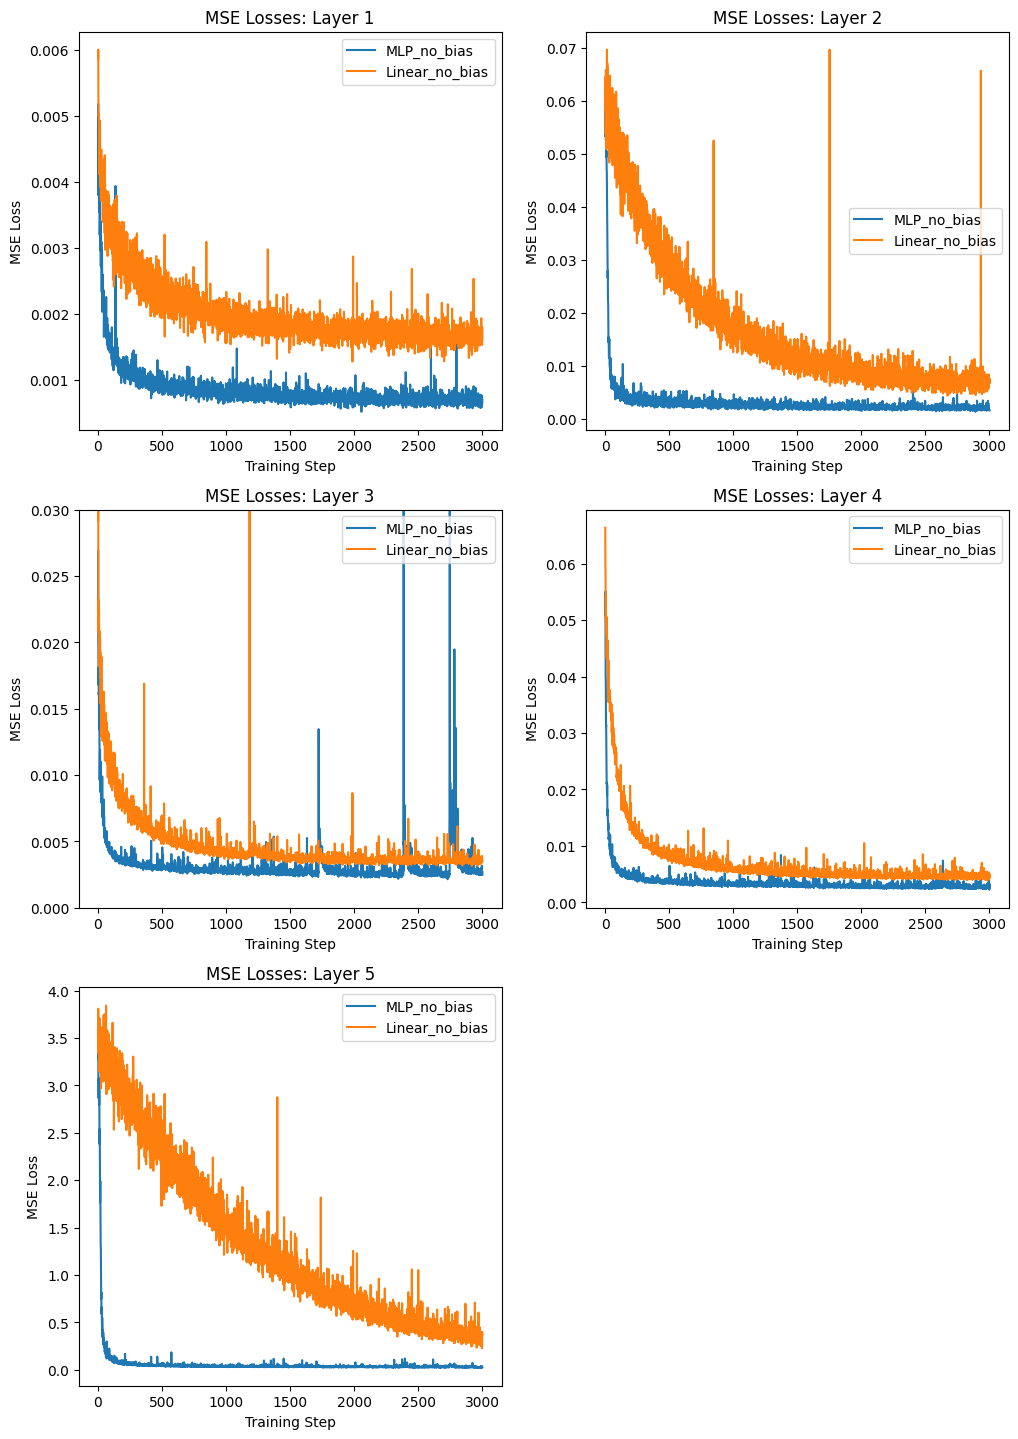

In [8]:
# Plot both losses
import matplotlib.pyplot as plt

num_columns = 2  # Two columns: one for each type of loss
num_rows = num_layers  # One row for each layer

plt.figure(figsize=(12, 6 * num_rows))  # Adjust the size as needed

for layer in range(num_layers):
    # make a new plot
    # plt.figure()
    plt.subplot(num_rows, num_columns, layer + 1)
    plt.title(f"MSE Losses: Layer {layer+1}")
    # plt.plot(two_nonlinear_losses[layer])
    # plt.plot(mlp_losses[layer])
    plt.plot(mlp_losses_no_bias[layer])
    # plt.plot(nonlinear_losses[layer])
    # plt.plot(nonlinear_losses_no_bias[layer])
    # plt.plot(linear_losses[layer])
    plt.plot(linear_losses_no_bias[layer])
    if(layer ==2):
        # set max y to 0.05
        plt.ylim(0, 0.03)
    # plt.legend(["Two Nonlinear", "MLP", "MLP_no_bias", "Nonlinear", "Nonlinear_no_bias", "Linear", "Linear_no_bias"])
    # plt.legend(["Two Nonlinear", "MLP", "Nonlinear", "Linear"])
    plt.legend(["MLP_no_bias", "Linear_no_bias"])
    plt.xlabel("Training Step")
    plt.ylabel("MSE Loss")
plt.show()

## Plot Feature-level losses

In [14]:
# Get the losses for each feature
mse = nn.MSELoss(reduction="none")
l1_alpha = 1e-3
batch_size = 32

# with dataset.formatted_as("pt"):
#     dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
max_batches = 100
num_alive_features = alive_features_ind.sum(dim=1).cpu()
loss_diff = [torch.zeros(num_alive_feat) for num_alive_feat in num_alive_features]
# loss_diff = torch.zeros((len(cache_names)//2, 1024))
norms = np.zeros(len(cache_names)//2)
with torch.no_grad():
    for i, batch in enumerate(tqdm(dataset)):
        batch = batch["input_ids"].to(device)
        with TraceDict(model, cache_names) as ret:
            _ = model(batch)
        
        for cache_name_ind in range(len(cache_names) // 2):

            input_cache_name = cache_names[cache_name_ind * 2]
            output_cache_name = cache_names[cache_name_ind * 2 + 1]
            input_autoencoder = autoencoders[cache_name_ind * 2]
            output_autoencoder = autoencoders[cache_name_ind * 2 + 1]
            input_activations = ret[input_cache_name].output
            output_activations = ret[output_cache_name].output

            if isinstance(input_activations, tuple):
                input_activations = input_activations[0]
            if isinstance(output_activations, tuple):
                output_activations = output_activations[0]

            input_internal_activations = rearrange(input_activations, "b s n -> (b s) n")
            output_internal_activations = rearrange(output_activations, "b s n -> (b s) n")

            if(i == 0):
                # Print the norms of both input & output
                print(f"Layer: {cache_name_ind+1}")
                print(f"Input Norms: {input_internal_activations.norm(dim=1).mean():.2f}")
                print(f"Output Norms: {output_internal_activations.norm(dim=1).mean():.2f}")
                norms[cache_name_ind] = output_internal_activations.norm(dim=1).mean().cpu()
                
            input_internal_activations = input_autoencoder.encode(input_internal_activations)
            output_internal_activations = output_autoencoder.encode(output_internal_activations)

            # if(i == 0):
                # Also check dead features
                # print(f"Input Dead Features: {(input_internal_activations.count_nonzero(dim=0) == 0).sum()}")
                # print(f"Output Dead Features: {(output_internal_activations.count_nonzero(dim=0) == 0).sum()}")

            # Run features through mlp & linear
            x_hat_mlp = mlp_weights_no_bias[cache_name_ind](input_internal_activations)
            x_hat_linear = linear_weights_no_bias[cache_name_ind](input_internal_activations)
            
            # Get ind of alive features
            current_alive_features_ind = alive_features_ind[cache_name_ind].nonzero(as_tuple=True)[0].to(device)
            index_x_hat_mlp = x_hat_mlp.index_select(dim=1, index=current_alive_features_ind)
            index_x_hat_linear = x_hat_linear.index_select(dim=1, index=current_alive_features_ind)
            index_output_internal_activations = output_internal_activations.index_select(dim=1, index=current_alive_features_ind)

            # We want to compare the MLP loss & linear loss
            # for every feature, so we mean the batch & pos, but not the feature
            mlp_loss = mse(index_x_hat_mlp, index_output_internal_activations).mean(dim=0).cpu()
            linear_loss = mse(index_x_hat_linear, index_output_internal_activations).mean(dim=0).cpu()

            # instead of mse, do cosine sim
            # mlp_loss = torch.cosine_similarity(x_hat_mlp, output_internal_activations, dim=1).cpu()
            # linear_loss = torch.cosine_similarity(x_hat_linear, output_internal_activations, dim=1).cpu()
            loss_diff[cache_name_ind] += linear_loss - mlp_loss
        if(i >= max_batches):
            break
loss_diff =  [loss_d / max_batches for loss_d in loss_diff]

  0%|          | 1/10963 [00:00<1:37:11,  1.88it/s]

Layer: 1
Input Norms: 7.20
Output Norms: 4.26
Layer: 2
Input Norms: 9.14
Output Norms: 6.81
Layer: 3
Input Norms: 13.24
Output Norms: 9.47
Layer: 4
Input Norms: 15.14
Output Norms: 13.14
Layer: 5
Input Norms: 16.36
Output Norms: 54.53


  1%|          | 100/10963 [00:11<20:03,  9.02it/s]


layer 0: 0.788
layer 1: 0.959
layer 2: 0.978
layer 3: 0.980
layer 4: 0.989


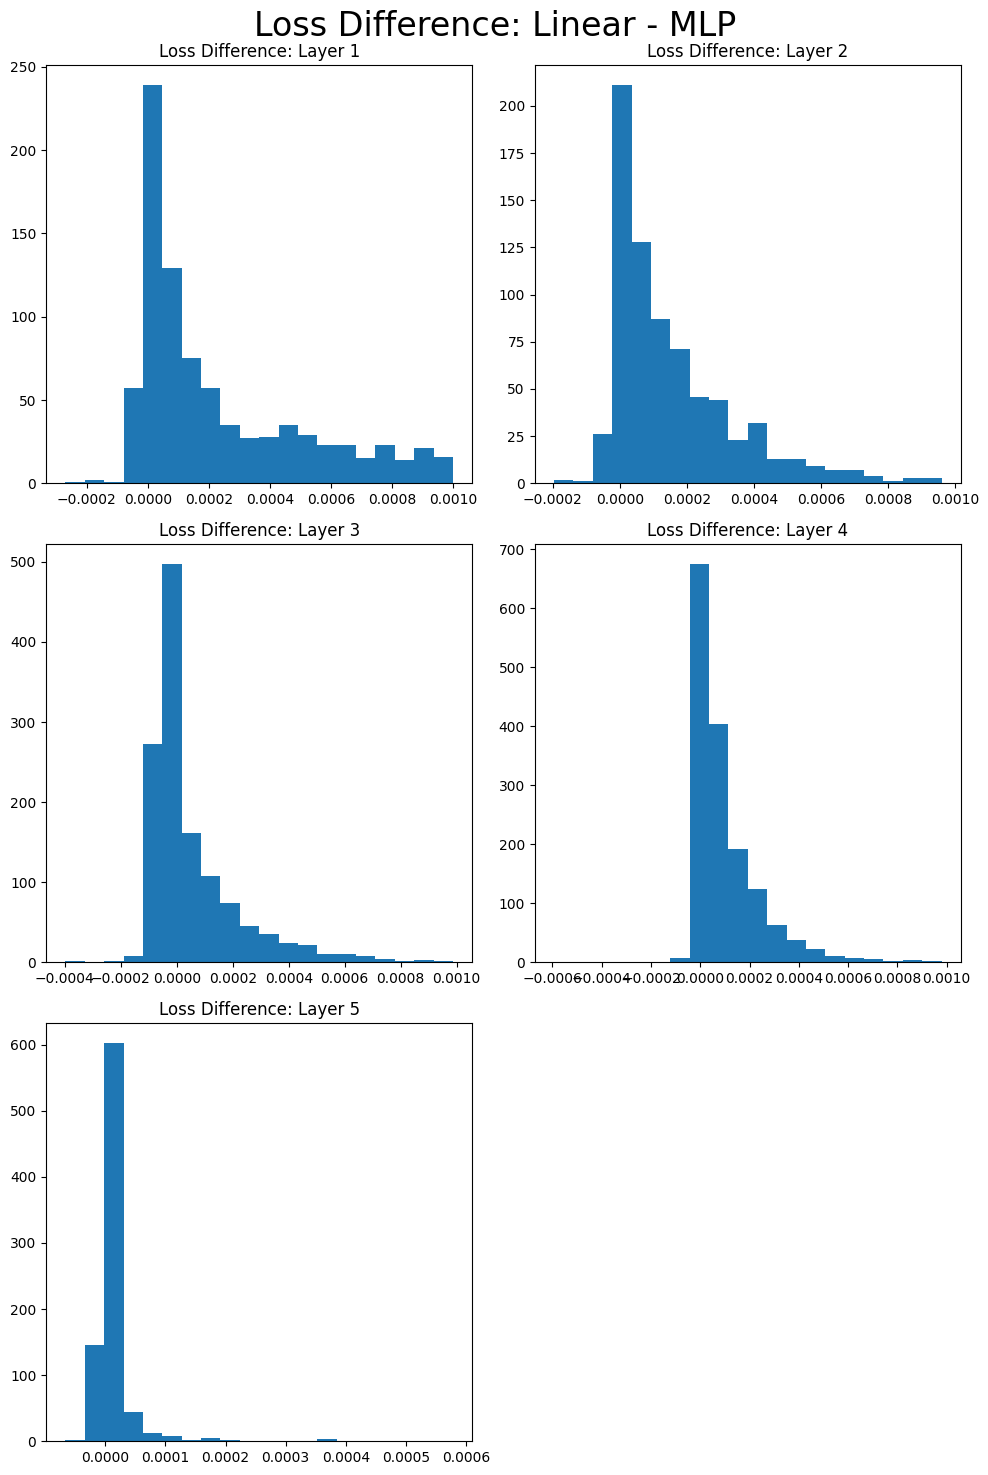

In [15]:
import matplotlib.pyplot as plt
normalization_per_layer = (norms/norms.min())**2

outlier_thresh =  10.0
num_layers = len(loss_diff)
num_columns = 2  # Adjust this for the desired number of plots per row
num_rows = (num_layers + num_columns - 1) // num_columns  # Calculate the number of rows needed

plt.figure(figsize=(10, 5 * num_rows))  # Adjust the size as needed
threshold = 0.001
for layer in range(num_layers):
    # print(f"Percentage of features above {threshold} for layer {layer}: {(loss_diff[layer] > threshold).sum() / len(loss_diff[layer])}")
    loss_d = loss_diff[layer].cpu().numpy() / normalization_per_layer[layer]
    # filtered = loss_d[~is_outlier(loss_d, outlier_thresh)]
    filtered = loss_d[loss_d < threshold]
    percent_below_threshold = loss_d[loss_d < threshold].shape[0] / loss_d.shape[0]
    print(f"layer {layer}: {percent_below_threshold:.3f}")
    plt.subplot(num_rows, num_columns, layer + 1)  # Create a subplot for each layer
    plt.title(f"Loss Difference: Layer {layer + 1}")
    plt.hist(filtered, bins = 20)
    # Uncomment the next line if you also want to print the percentage above threshold
    # print(f"Percentage of features above {threshold} for layer {layer}: {(loss_diff[layer] > threshold).sum() / len(loss_diff[layer])}")
plt.suptitle("Loss Difference: Linear - MLP", fontsize=24)
plt.tight_layout()
plt.show()

layer 0: torch.return_types.topk(
values=tensor([0.1401, 0.0860, 0.0159, 0.0150, 0.0125]),
indices=tensor([ 870,  671,  502,  787, 1035]))
layer 1: torch.return_types.topk(
values=tensor([0.3370, 0.3324, 0.2910, 0.1682, 0.1069]),
indices=tensor([706, 303, 594, 392,  70]))
layer 2: torch.return_types.topk(
values=tensor([0.0456, 0.0163, 0.0122, 0.0101, 0.0069]),
indices=tensor([ 643, 1082,  470, 1193,  396]))
layer 3: torch.return_types.topk(
values=tensor([0.0529, 0.0134, 0.0106, 0.0106, 0.0099]),
indices=tensor([  35, 1492,   37, 1390, 1243]))
layer 4: torch.return_types.topk(
values=tensor([1.5555, 0.0116, 0.0052, 0.0040, 0.0038]),
indices=tensor([752, 348,  63, 684, 228]))


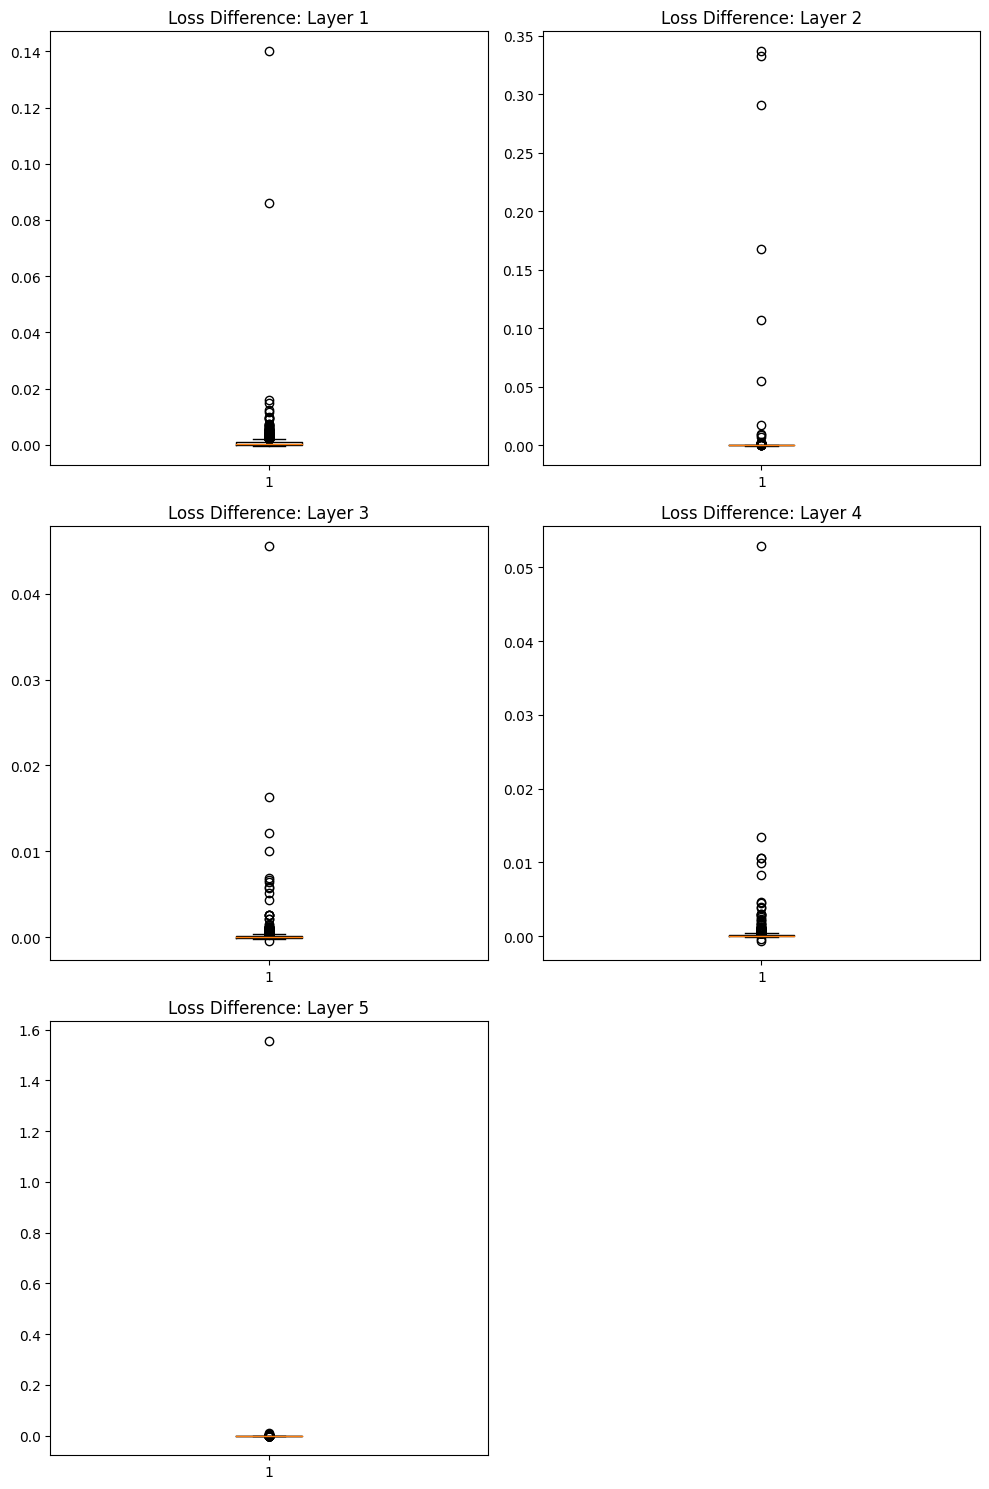

In [17]:
import matplotlib.pyplot as plt

num_layers = len(loss_diff)
num_columns = 2  # Adjust this for the desired number of plots per row
num_rows = (num_layers + num_columns - 1) // num_columns  # Calculate the number of rows needed

plt.figure(figsize=(10, 5 * num_rows))  # Adjust the size as needed
threshold = 0.01
for layer in range(num_layers):
    # print(f"Percentage of features above {threshold} for layer {layer}: {(loss_diff[layer] > threshold).sum() / len(loss_diff[layer])}")
    loss_d = loss_diff[layer].cpu().numpy()/ normalization_per_layer[layer]
    # print the topk ind of features
    topk = 5
    print(f"layer {layer}: {torch.tensor(loss_d).topk(topk)}")
    plt.subplot(num_rows, num_columns, layer + 1)  # Create a subplot for each layer
    plt.title(f"Loss Difference: Layer {layer + 1}")
    plt.boxplot(loss_d)
    # Uncomment the next line if you also want to print the percentage above threshold
    # print(f"Percentage of features above {threshold} for layer {layer}: {(loss_diff[layer] > threshold).sum() / len(loss_diff[layer])}")

plt.tight_layout()
plt.show()

torch.return_types.topk(
values=tensor([1.3722e+01, 4.6175e-02, 1.7231e-02, 1.0577e-02, 2.8266e-03]),
indices=tensor([758, 136, 211, 481, 349]))

# Find linearly computed features & MLP ones

In [20]:
linear_features = []
mlp_features = []
threshold = 0.001
for layer in range(num_layers):
    loss_d = loss_diff[layer].cpu().numpy() / normalization_per_layer[layer]
    linear_ind = loss_d <= threshold
    linear_features.append(linear_ind)
    
    mlp_ind = loss_d > threshold
    mlp_features.append(mlp_ind)
# Save the features to file
import pickle
with open("linear_features.pkl", "wb") as f:
    pickle.dump(linear_features, f)
with open("mlp_features.pkl", "wb") as f:
    pickle.dump(mlp_features, f)
# Also save alive features
with open("alive_features.pkl", "wb") as f:
    pickle.dump(alive_features_ind, f)

In [6]:
# Load in the features
import pickle
with open("linear_features.pkl", "rb") as f:
    linear_features = pickle.load(f)
with open("mlp_features.pkl", "rb") as f:
    mlp_features = pickle.load(f)
with open("alive_features.pkl", "rb") as f:
    alive_features_ind = pickle.load(f)

## Pareto frontier of l1 alpha for linear layer (no bias), then MLP (no bias)

In [7]:
# Let's just think about this for 1 layer
# If we're doing 10-different l1 alpha terms, then we have 10 different sparse weights
mlp_weights_no_bias = []
linear_weights_no_bias = []

mlp_optimizers_no_bias = []
linear_optimizers_no_bias = []
l1_alpha = 8
for layer in range(num_layers): # This is per layer
    num_linear_features = linear_features[layer].sum()
    num_mlp_features = mlp_features[layer].sum()
    mlp_weights_no_bias.append([])
    linear_weights_no_bias.append([])
    mlp_optimizers_no_bias.append([])
    linear_optimizers_no_bias.append([])
    for l1_alpha_ind in range(l1_alpha):
        mlp_weights_no_bias[-1].append(mlp_no_bias(num_features, output_size=num_mlp_features))
        mlp_optimizers_no_bias[-1].append(Adam(mlp_weights_no_bias[-1][-1].parameters(), lr=1e-3))
        linear_weights_no_bias[-1].append(linear_no_bias(num_features, output_size=num_linear_features))
        linear_optimizers_no_bias[-1].append(Adam(linear_weights_no_bias[-1][-1].parameters(), lr=1e-3))

In [23]:

def train_sparse_model(model, dataset, device, sparse_weights, autoencoders, cache_names, optimizers, l1_alphas, feature_ind, max_batches = 500, hidden_l1_loss=False):
    mse = nn.MSELoss()
    losses = [[[] for _ in range(len(l1_alphas))] for _ in range(len(sparse_weights))]
    losses_mse = [[[] for _ in range(len(l1_alphas))] for _ in range(len(sparse_weights))]
    losses_l1 = [[[] for _ in range(len(l1_alphas))] for _ in range(len(sparse_weights))]
    
    # with dataset.formatted_as("pt"):
    #     dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for i, batch in enumerate(tqdm(dataset)):
        batch = batch["input_ids"].to(device)
        with torch.no_grad():
            with TraceDict(model, cache_names) as ret:
                _ = model(batch)
        
        for cache_name_ind in range(len(cache_names) // 2):
            with torch.no_grad():
                input_cache_name = cache_names[cache_name_ind * 2]
                output_cache_name = cache_names[cache_name_ind * 2 + 1]
                input_autoencoder = autoencoders[cache_name_ind * 2]
                output_autoencoder = autoencoders[cache_name_ind * 2 + 1]
                input_activations = ret[input_cache_name].output
                output_activations = ret[output_cache_name].output

                if isinstance(input_activations, tuple):
                    input_activations = input_activations[0]
                if isinstance(output_activations, tuple):
                    output_activations = output_activations[0]

                input_internal_activations = rearrange(input_activations, "b s n -> (b s) n")
                output_internal_activations = rearrange(output_activations, "b s n -> (b s) n")

                input_internal_activations = input_autoencoder.encode(input_internal_activations)
                output_internal_activations = output_autoencoder.encode(output_internal_activations)

            for l1_alpha_ind, l1_alpha in enumerate(l1_alphas):
                sparse_weight = sparse_weights[cache_name_ind][l1_alpha_ind].to(device)
                x_hat = sparse_weight(input_internal_activations)

                # Find ind of alive features & selected features (linear or MLP features)
                alive_features = alive_features_ind[cache_name_ind].nonzero(as_tuple=True)[0]
                alive_and_selected_features = alive_features[feature_ind[cache_name_ind]].to(device)
                indexed_x_hat = x_hat
                indexed_output_internal_activations = output_internal_activations.index_select(dim=1, index=alive_and_selected_features)
                
                # Divide MSE_loss by normalization factor
                mse_loss = mse(indexed_x_hat, indexed_output_internal_activations) / normalization_per_layer[cache_name_ind]
                l1_loss = torch.norm(sparse_weight.linear.weight, dim=1, p=1).mean()
                # check if sparse_weight.linear2 exists
                if hasattr(sparse_weight, "linear2"):
                    l1_loss += torch.norm(sparse_weight.linear2.weight, dim=1, p=1).mean()
                    l1_loss /= 2
                unweighted_loss = mse_loss + l1_loss
                loss = mse_loss + l1_alpha * l1_loss
                if(hidden_l1_loss):
                    hidden_loss = torch.norm(sparse_weight.linear.weight, dim=0, p=1).mean()
                    unweighted_loss += hidden_loss
                    loss += l1_alpha * hidden_loss

                loss.backward()
                optimizers[cache_name_ind][l1_alpha_ind].step()
                optimizers[cache_name_ind][l1_alpha_ind].zero_grad()
                losses[cache_name_ind][l1_alpha_ind].append(unweighted_loss.item())
                losses_mse[cache_name_ind][l1_alpha_ind].append(mse_loss.item())
                losses_l1[cache_name_ind][l1_alpha_ind].append(l1_loss.item())

                sparse_weight = sparse_weight.to("cpu")
                if i % 100 == 0:
                    print(f"Layers: {cache_name_ind} | l1 alpha MSE Loss: {mse_loss.item()} | L1 Loss: {l1_loss.item()}")

                del x_hat, indexed_x_hat, indexed_output_internal_activations, loss, l1_loss, mse_loss, unweighted_loss, alive_and_selected_features
                torch.cuda.empty_cache()
        if i > max_batches:
            # Stop training after 1000 batches
            break
    return losses, losses_mse, losses_l1


In [ ]:

# l1_alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10, 50, 100]
l1_alphas = [1e-7, 1e-5, 1e-3, .1, 10, 100]
# l1_alphas = [1e-4, 0.01, .1, 1, 10]

mlp_losses_no_bias, mlp_losses_no_bias_mse, mlp_losses_no_bias_l1 = train_sparse_model(model, dataset, device, mlp_weights_no_bias, autoencoders, cache_names, mlp_optimizers_no_bias, l1_alphas, mlp_features)
linear_losses_no_bias, linear_losses_no_bias_mse, linear_losses_no_bias_l1 = train_sparse_model(model, dataset, device, linear_weights_no_bias, autoencoders, cache_names, linear_optimizers_no_bias, l1_alphas, linear_features)

In [25]:
# Plot both losses, just the last value for both MSE and L1
import matplotlib.pyplot as plt

num_layers = len(mlp_losses_no_bias)
num_columns = 2  # Two columns: one for each type of loss
num_rows = num_layers  # One row for each layer

l1_alpha_num = len(l1_alphas)
mlp_mse_losses_last = np.zeros((num_layers, l1_alpha_num))
mlp_l1_losses_last = np.zeros((num_layers, l1_alpha_num))
linear_mse_losses_last = np.zeros((num_layers, l1_alpha_num))
linear_l1_losses_last = np.zeros((num_layers, l1_alpha_num))
for layer in range(num_layers):
    for l1_alpha_ind, l1_alpha in enumerate(l1_alphas):
        mlp_mse_losses_last[layer, l1_alpha_ind] = mlp_losses_no_bias_mse[layer][l1_alpha_ind][-1]
        mlp_l1_losses_last[layer, l1_alpha_ind] = mlp_losses_no_bias_l1[layer][l1_alpha_ind][-1]
        linear_mse_losses_last[layer, l1_alpha_ind] = linear_losses_no_bias_mse[layer][l1_alpha_ind][-1]
        linear_l1_losses_last[layer, l1_alpha_ind] = linear_losses_no_bias_l1[layer][l1_alpha_ind][-1]


plt.figure(figsize=(12, 6 * num_rows))  # Adjust the size as needed

for layer in range(num_layers):
    # Subplot for MSE Loss
    plt.subplot(num_rows, num_columns, layer+1)
    plt.title(f"MSE vs L1 : Layer {layer+1}")
    # Grabe the last value of MSE and L1
    mlp_l1_loss = mlp_l1_losses_last[layer] 
    mlp_mse_loss = mlp_mse_losses_last[layer] 
    linear_l1_loss = linear_l1_losses_last[layer] 
    linear_mse_loss = linear_mse_losses_last[layer] 
    # Plot
    plt.plot(mlp_l1_loss, mlp_mse_loss, 'o', label="MLP_no_bias")
    plt.plot(linear_l1_loss, linear_mse_loss, 'o', label="Linear_no_bias")
    plt.xlabel("L1 Loss")
    plt.ylabel("MSE Loss")
    # put both on logplot
    # plt.yscale('log')
    plt.xscale('log')
    plt.legend()
plt.show()

IndexError: list index out of range

# Optimize one sparse model for a long time

In [24]:
# Let's just think about this for 1 layer
# If we're doing 10-different l1 alpha terms, then we have 10 different sparse weights
mlp_weights_no_bias = []
linear_weights_no_bias = []

mlp_optimizers_no_bias = []
linear_optimizers_no_bias = []
l1_alpha = 1
for layer in range(num_layers): # This is per layer
    num_linear_features = linear_features[layer].sum()
    num_mlp_features = mlp_features[layer].sum()
    mlp_weights_no_bias.append([])
    linear_weights_no_bias.append([])
    mlp_optimizers_no_bias.append([])
    linear_optimizers_no_bias.append([])
    for l1_alpha_ind in range(l1_alpha):
        mlp_weights_no_bias[-1].append(mlp_no_bias(num_features, output_size=num_mlp_features))
        mlp_optimizers_no_bias[-1].append(Adam(mlp_weights_no_bias[-1][-1].parameters(), lr=1e-3))
        linear_weights_no_bias[-1].append(linear_no_bias(num_features, output_size=num_linear_features))
        linear_optimizers_no_bias[-1].append(Adam(linear_weights_no_bias[-1][-1].parameters(), lr=1e-3))

In [25]:
l1_alphas = [8e-4]
max_batches = 3000
mlp_losses_no_bias, mlp_losses_no_bias_mse, mlp_losses_no_bias_l1 = train_sparse_model(model, dataset, device, mlp_weights_no_bias, autoencoders, cache_names, mlp_optimizers_no_bias, l1_alphas, mlp_features, max_batches=max_batches)
linear_losses_no_bias, linear_losses_no_bias_mse, linear_losses_no_bias_l1 = train_sparse_model(model, dataset, device, linear_weights_no_bias, autoencoders, cache_names, linear_optimizers_no_bias, l1_alphas, linear_features, max_batches=max_batches)

  0%|          | 0/10963 [00:00<?, ?it/s]

Layers: 0 | l1 alpha MSE Loss: 0.011997264809906483 | L1 Loss: 27.708736419677734
Layers: 1 | l1 alpha MSE Loss: 0.5747371315956116 | L1 Loss: 27.671335220336914
Layers: 2 | l1 alpha MSE Loss: 0.11847595870494843 | L1 Loss: 27.747163772583008
Layers: 3 | l1 alpha MSE Loss: 0.19381678104400635 | L1 Loss: 27.711936950683594


  0%|          | 1/10963 [00:00<2:23:53,  1.27it/s]

Layers: 4 | l1 alpha MSE Loss: 2.013000249862671 | L1 Loss: 27.783546447753906


  1%|          | 100/10963 [00:34<1:00:10,  3.01it/s]

Layers: 0 | l1 alpha MSE Loss: 0.006543758325278759 | L1 Loss: 2.6212146282196045
Layers: 1 | l1 alpha MSE Loss: 0.03325902670621872 | L1 Loss: 18.156299591064453
Layers: 2 | l1 alpha MSE Loss: 0.014121967367827892 | L1 Loss: 10.05138111114502
Layers: 3 | l1 alpha MSE Loss: 0.010056840255856514 | L1 Loss: 9.681305885314941


  1%|          | 101/10963 [00:35<59:51,  3.02it/s]  

Layers: 4 | l1 alpha MSE Loss: 0.052065830677747726 | L1 Loss: 21.872802734375


  2%|▏         | 200/10963 [01:04<49:36,  3.62it/s]  

Layers: 0 | l1 alpha MSE Loss: 0.004965449217706919 | L1 Loss: 2.4414260387420654
Layers: 1 | l1 alpha MSE Loss: 0.03318862244486809 | L1 Loss: 15.588093757629395
Layers: 2 | l1 alpha MSE Loss: 0.01217240747064352 | L1 Loss: 7.743060111999512
Layers: 3 | l1 alpha MSE Loss: 0.0082315094769001 | L1 Loss: 7.678687572479248
Layers: 4 | l1 alpha MSE Loss: 0.03180810809135437 | L1 Loss: 19.19195556640625


  3%|▎         | 300/10963 [01:36<55:43,  3.19it/s]  

Layers: 0 | l1 alpha MSE Loss: 0.004453396890312433 | L1 Loss: 2.423583507537842
Layers: 1 | l1 alpha MSE Loss: 0.037043824791908264 | L1 Loss: 14.405471801757812
Layers: 2 | l1 alpha MSE Loss: 0.00998383853584528 | L1 Loss: 6.562058448791504
Layers: 3 | l1 alpha MSE Loss: 0.009288201108574867 | L1 Loss: 6.655252456665039


  3%|▎         | 301/10963 [01:37<55:00,  3.23it/s]

Layers: 4 | l1 alpha MSE Loss: 0.03074111044406891 | L1 Loss: 17.207944869995117


  4%|▎         | 401/10963 [02:08<47:03,  3.74it/s]  

Layers: 0 | l1 alpha MSE Loss: 0.003506834851577878 | L1 Loss: 2.439516544342041
Layers: 1 | l1 alpha MSE Loss: 0.04922456666827202 | L1 Loss: 13.669270515441895
Layers: 2 | l1 alpha MSE Loss: 0.009803642518818378 | L1 Loss: 5.8143768310546875
Layers: 3 | l1 alpha MSE Loss: 0.00970937218517065 | L1 Loss: 6.022095680236816
Layers: 4 | l1 alpha MSE Loss: 0.03313453495502472 | L1 Loss: 15.840743064880371


  5%|▍         | 501/10963 [02:38<47:55,  3.64it/s]

Layers: 0 | l1 alpha MSE Loss: 0.004710300825536251 | L1 Loss: 2.340985059738159
Layers: 1 | l1 alpha MSE Loss: 0.024295954033732414 | L1 Loss: 13.180914878845215
Layers: 2 | l1 alpha MSE Loss: 0.009019465185701847 | L1 Loss: 5.300899505615234
Layers: 3 | l1 alpha MSE Loss: 0.0068712374195456505 | L1 Loss: 5.725592613220215
Layers: 4 | l1 alpha MSE Loss: 0.021104134619235992 | L1 Loss: 14.93978500366211


  5%|▌         | 601/10963 [03:05<47:32,  3.63it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0032249654177576303 | L1 Loss: 2.2704806327819824
Layers: 1 | l1 alpha MSE Loss: 0.020526044070720673 | L1 Loss: 12.788614273071289
Layers: 2 | l1 alpha MSE Loss: 0.00972903985530138 | L1 Loss: 4.951994895935059
Layers: 3 | l1 alpha MSE Loss: 0.00829476397484541 | L1 Loss: 5.044472694396973
Layers: 4 | l1 alpha MSE Loss: 0.02659621275961399 | L1 Loss: 14.145973205566406


  6%|▋         | 701/10963 [03:33<47:58,  3.56it/s]  

Layers: 0 | l1 alpha MSE Loss: 0.0026154571678489447 | L1 Loss: 2.2436130046844482
Layers: 1 | l1 alpha MSE Loss: 0.033241286873817444 | L1 Loss: 12.394393920898438
Layers: 2 | l1 alpha MSE Loss: 0.01250381488353014 | L1 Loss: 4.590096950531006
Layers: 3 | l1 alpha MSE Loss: 0.007746475283056498 | L1 Loss: 4.715106010437012
Layers: 4 | l1 alpha MSE Loss: 0.024908820167183876 | L1 Loss: 13.720962524414062


  7%|▋         | 801/10963 [04:01<44:30,  3.80it/s]

Layers: 0 | l1 alpha MSE Loss: 0.004179676063358784 | L1 Loss: 2.1956095695495605
Layers: 1 | l1 alpha MSE Loss: 0.017110655084252357 | L1 Loss: 12.069793701171875
Layers: 2 | l1 alpha MSE Loss: 0.008275645785033703 | L1 Loss: 4.3787336349487305
Layers: 3 | l1 alpha MSE Loss: 0.005701515357941389 | L1 Loss: 4.638045310974121
Layers: 4 | l1 alpha MSE Loss: 0.019557146355509758 | L1 Loss: 13.155923843383789


  8%|▊         | 901/10963 [04:29<46:13,  3.63it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0036076935939490795 | L1 Loss: 2.1716866493225098
Layers: 1 | l1 alpha MSE Loss: 0.034545816481113434 | L1 Loss: 11.456260681152344
Layers: 2 | l1 alpha MSE Loss: 0.009460685774683952 | L1 Loss: 4.188669204711914
Layers: 3 | l1 alpha MSE Loss: 0.006531510967761278 | L1 Loss: 4.47378396987915
Layers: 4 | l1 alpha MSE Loss: 0.020331133157014847 | L1 Loss: 12.529090881347656


  9%|▉         | 1001/10963 [04:57<44:05,  3.77it/s] 

Layers: 0 | l1 alpha MSE Loss: 0.004125060513615608 | L1 Loss: 2.1441731452941895
Layers: 1 | l1 alpha MSE Loss: 0.01987098902463913 | L1 Loss: 11.422016143798828
Layers: 2 | l1 alpha MSE Loss: 0.008174010552465916 | L1 Loss: 3.97446870803833
Layers: 3 | l1 alpha MSE Loss: 0.008472850546240807 | L1 Loss: 4.114040374755859
Layers: 4 | l1 alpha MSE Loss: 0.023579062893986702 | L1 Loss: 12.080381393432617


 10%|█         | 1100/10963 [05:24<44:55,  3.66it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0037982494104653597 | L1 Loss: 2.1431336402893066
Layers: 1 | l1 alpha MSE Loss: 0.02495715208351612 | L1 Loss: 11.254396438598633
Layers: 2 | l1 alpha MSE Loss: 0.007446044124662876 | L1 Loss: 3.923394203186035
Layers: 3 | l1 alpha MSE Loss: 0.008737298659980297 | L1 Loss: 3.9532864093780518
Layers: 4 | l1 alpha MSE Loss: 0.026389380916953087 | L1 Loss: 11.639839172363281


 11%|█         | 1200/10963 [05:53<45:13,  3.60it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0033680114429444075 | L1 Loss: 2.1051275730133057
Layers: 1 | l1 alpha MSE Loss: 0.015157194808125496 | L1 Loss: 10.756807327270508
Layers: 2 | l1 alpha MSE Loss: 0.008116432465612888 | L1 Loss: 3.792435646057129
Layers: 3 | l1 alpha MSE Loss: 0.006014630664139986 | L1 Loss: 3.8001060485839844


 11%|█         | 1201/10963 [05:53<46:20,  3.51it/s]

Layers: 4 | l1 alpha MSE Loss: 0.018755938857793808 | L1 Loss: 11.300838470458984


 12%|█▏        | 1300/10963 [06:23<45:42,  3.52it/s]  

Layers: 0 | l1 alpha MSE Loss: 0.0031500253826379776 | L1 Loss: 2.068551540374756
Layers: 1 | l1 alpha MSE Loss: 0.015510640107095242 | L1 Loss: 10.651512145996094
Layers: 2 | l1 alpha MSE Loss: 0.008872102946043015 | L1 Loss: 3.682588577270508
Layers: 3 | l1 alpha MSE Loss: 0.005110492929816246 | L1 Loss: 3.621786117553711


 12%|█▏        | 1301/10963 [06:23<46:31,  3.46it/s]

Layers: 4 | l1 alpha MSE Loss: 0.01667971909046173 | L1 Loss: 10.751642227172852


 13%|█▎        | 1401/10963 [06:53<41:39,  3.83it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0029389874543994665 | L1 Loss: 2.0472464561462402
Layers: 1 | l1 alpha MSE Loss: 0.023434216156601906 | L1 Loss: 10.532968521118164
Layers: 2 | l1 alpha MSE Loss: 0.0086544593796134 | L1 Loss: 3.6183440685272217
Layers: 3 | l1 alpha MSE Loss: 0.0065701305866241455 | L1 Loss: 3.5311107635498047
Layers: 4 | l1 alpha MSE Loss: 0.020447708666324615 | L1 Loss: 10.506401062011719


 14%|█▎        | 1500/10963 [07:20<43:40,  3.61it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0030344664119184017 | L1 Loss: 2.053062677383423
Layers: 1 | l1 alpha MSE Loss: 0.014441581442952156 | L1 Loss: 10.277868270874023
Layers: 2 | l1 alpha MSE Loss: 0.008629053831100464 | L1 Loss: 3.514103412628174
Layers: 3 | l1 alpha MSE Loss: 0.006516812834888697 | L1 Loss: 3.4566383361816406
Layers: 4 | l1 alpha MSE Loss: 0.020791837945580482 | L1 Loss: 10.27286148071289


 15%|█▍        | 1601/10963 [07:48<43:08,  3.62it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0030382471159100533 | L1 Loss: 1.9961460828781128
Layers: 1 | l1 alpha MSE Loss: 0.021718250587582588 | L1 Loss: 10.019956588745117
Layers: 2 | l1 alpha MSE Loss: 0.008827920071780682 | L1 Loss: 3.457313060760498
Layers: 3 | l1 alpha MSE Loss: 0.005976531654596329 | L1 Loss: 3.390794515609741
Layers: 4 | l1 alpha MSE Loss: 0.0179373100399971 | L1 Loss: 9.866628646850586


 16%|█▌        | 1700/10963 [08:21<57:11,  2.70it/s]  

Layers: 0 | l1 alpha MSE Loss: 0.0030446224845945835 | L1 Loss: 1.9719221591949463
Layers: 1 | l1 alpha MSE Loss: 0.018802350386977196 | L1 Loss: 9.879976272583008
Layers: 2 | l1 alpha MSE Loss: 0.008115594275295734 | L1 Loss: 3.383967399597168


 16%|█▌        | 1701/10963 [08:21<1:00:36,  2.55it/s]

Layers: 3 | l1 alpha MSE Loss: 0.005941202864050865 | L1 Loss: 3.251965045928955
Layers: 4 | l1 alpha MSE Loss: 0.02198401652276516 | L1 Loss: 9.59384536743164


 16%|█▋        | 1800/10963 [08:51<43:30,  3.51it/s]  

Layers: 0 | l1 alpha MSE Loss: 0.0029702791944146156 | L1 Loss: 1.955492615699768
Layers: 1 | l1 alpha MSE Loss: 0.01723286136984825 | L1 Loss: 9.782759666442871
Layers: 2 | l1 alpha MSE Loss: 0.009401489049196243 | L1 Loss: 3.35237717628479
Layers: 3 | l1 alpha MSE Loss: 0.01038992591202259 | L1 Loss: 3.157665729522705


 16%|█▋        | 1801/10963 [08:52<43:59,  3.47it/s]

Layers: 4 | l1 alpha MSE Loss: 0.16602249443531036 | L1 Loss: 9.057584762573242


 17%|█▋        | 1900/10963 [09:20<42:28,  3.56it/s]

Layers: 0 | l1 alpha MSE Loss: 0.003453602781519294 | L1 Loss: 1.952643632888794
Layers: 1 | l1 alpha MSE Loss: 0.017223786562681198 | L1 Loss: 9.703109741210938
Layers: 2 | l1 alpha MSE Loss: 0.010124141350388527 | L1 Loss: 3.2873473167419434
Layers: 3 | l1 alpha MSE Loss: 0.00701091717928648 | L1 Loss: 3.1246700286865234


 17%|█▋        | 1901/10963 [09:21<42:40,  3.54it/s]

Layers: 4 | l1 alpha MSE Loss: 0.01981796883046627 | L1 Loss: 9.213401794433594


 18%|█▊        | 2000/10963 [09:51<53:59,  2.77it/s]

Layers: 0 | l1 alpha MSE Loss: 0.003409289987757802 | L1 Loss: 1.917984127998352
Layers: 1 | l1 alpha MSE Loss: 0.020567506551742554 | L1 Loss: 9.408909797668457
Layers: 2 | l1 alpha MSE Loss: 0.00751033890992403 | L1 Loss: 3.263828992843628
Layers: 3 | l1 alpha MSE Loss: 0.004943861626088619 | L1 Loss: 3.0382399559020996


 18%|█▊        | 2001/10963 [09:51<52:45,  2.83it/s]

Layers: 4 | l1 alpha MSE Loss: 0.01572577841579914 | L1 Loss: 8.821881294250488


 19%|█▉        | 2100/10963 [10:24<47:32,  3.11it/s]  

Layers: 0 | l1 alpha MSE Loss: 0.0025564832612872124 | L1 Loss: 1.9136935472488403
Layers: 1 | l1 alpha MSE Loss: 0.014234917238354683 | L1 Loss: 9.247772216796875
Layers: 2 | l1 alpha MSE Loss: 0.007997858338057995 | L1 Loss: 3.21086049079895
Layers: 3 | l1 alpha MSE Loss: 0.005773433018475771 | L1 Loss: 2.9923317432403564


 19%|█▉        | 2101/10963 [10:25<50:00,  2.95it/s]

Layers: 4 | l1 alpha MSE Loss: 0.014211664907634258 | L1 Loss: 8.354820251464844


 20%|██        | 2201/10963 [10:56<39:52,  3.66it/s]

Layers: 0 | l1 alpha MSE Loss: 0.002553911181166768 | L1 Loss: 1.9013450145721436
Layers: 1 | l1 alpha MSE Loss: 0.01614324375987053 | L1 Loss: 9.222941398620605
Layers: 2 | l1 alpha MSE Loss: 0.008755923248827457 | L1 Loss: 3.190462112426758
Layers: 3 | l1 alpha MSE Loss: 0.006038464140146971 | L1 Loss: 2.9547781944274902
Layers: 4 | l1 alpha MSE Loss: 0.023926351219415665 | L1 Loss: 8.129108428955078


 21%|██        | 2300/10963 [11:26<54:09,  2.67it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0028415818233042955 | L1 Loss: 1.8991724252700806
Layers: 1 | l1 alpha MSE Loss: 0.015433109365403652 | L1 Loss: 9.080117225646973
Layers: 2 | l1 alpha MSE Loss: 0.0087721087038517 | L1 Loss: 3.1444573402404785
Layers: 3 | l1 alpha MSE Loss: 0.0068852463737130165 | L1 Loss: 2.9575726985931396


 21%|██        | 2301/10963 [11:27<53:16,  2.71it/s]

Layers: 4 | l1 alpha MSE Loss: 0.01925520971417427 | L1 Loss: 7.879019737243652


 22%|██▏       | 2400/10963 [12:00<40:56,  3.49it/s]  

Layers: 0 | l1 alpha MSE Loss: 0.0025456976145505905 | L1 Loss: 1.8712706565856934
Layers: 1 | l1 alpha MSE Loss: 0.01807340234518051 | L1 Loss: 9.41128158569336
Layers: 2 | l1 alpha MSE Loss: 0.009267015382647514 | L1 Loss: 3.1230340003967285
Layers: 3 | l1 alpha MSE Loss: 0.005930713377892971 | L1 Loss: 2.8947458267211914
Layers: 4 | l1 alpha MSE Loss: 0.017881037667393684 | L1 Loss: 7.799265384674072


 23%|██▎       | 2500/10963 [12:35<58:53,  2.40it/s]  

Layers: 0 | l1 alpha MSE Loss: 0.0031395312398672104 | L1 Loss: 1.8483437299728394
Layers: 1 | l1 alpha MSE Loss: 0.028864989057183266 | L1 Loss: 8.904754638671875
Layers: 2 | l1 alpha MSE Loss: 0.008336415514349937 | L1 Loss: 3.0695323944091797


 23%|██▎       | 2501/10963 [12:36<56:23,  2.50it/s]

Layers: 3 | l1 alpha MSE Loss: 0.006018451880663633 | L1 Loss: 2.8236289024353027
Layers: 4 | l1 alpha MSE Loss: 0.01749221608042717 | L1 Loss: 7.736228942871094


 24%|██▎       | 2600/10963 [13:06<45:39,  3.05it/s]

Layers: 0 | l1 alpha MSE Loss: 0.002734928159043193 | L1 Loss: 1.8485419750213623
Layers: 1 | l1 alpha MSE Loss: 0.010493777692317963 | L1 Loss: 8.88906192779541
Layers: 2 | l1 alpha MSE Loss: 0.006272002588957548 | L1 Loss: 3.07275652885437
Layers: 3 | l1 alpha MSE Loss: 0.005839491728693247 | L1 Loss: 2.8091816902160645


 24%|██▎       | 2601/10963 [13:06<44:33,  3.13it/s]

Layers: 4 | l1 alpha MSE Loss: 0.025239910930395126 | L1 Loss: 7.654260635375977


 25%|██▍       | 2700/10963 [13:38<42:06,  3.27it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0032106933649629354 | L1 Loss: 1.8305643796920776
Layers: 1 | l1 alpha MSE Loss: 0.022368350997567177 | L1 Loss: 8.667616844177246
Layers: 2 | l1 alpha MSE Loss: 0.007644842844456434 | L1 Loss: 3.0753700733184814
Layers: 3 | l1 alpha MSE Loss: 0.0066329785622656345 | L1 Loss: 2.9979538917541504
Layers: 4 | l1 alpha MSE Loss: 0.024659957736730576 | L1 Loss: 8.030257225036621


 26%|██▌       | 2801/10963 [14:11<40:49,  3.33it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0029792464338243008 | L1 Loss: 1.8169035911560059
Layers: 1 | l1 alpha MSE Loss: 0.012958443723618984 | L1 Loss: 8.727374076843262
Layers: 2 | l1 alpha MSE Loss: 0.008896112442016602 | L1 Loss: 3.0139575004577637
Layers: 3 | l1 alpha MSE Loss: 0.006938471924513578 | L1 Loss: 2.7907028198242188
Layers: 4 | l1 alpha MSE Loss: 0.022392617538571358 | L1 Loss: 7.644898891448975


 26%|██▋       | 2900/10963 [14:44<43:04,  3.12it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0024525197222828865 | L1 Loss: 1.799096941947937
Layers: 1 | l1 alpha MSE Loss: 0.01229125913232565 | L1 Loss: 8.614860534667969
Layers: 2 | l1 alpha MSE Loss: 0.007464940659701824 | L1 Loss: 2.994967222213745
Layers: 3 | l1 alpha MSE Loss: 0.004755722358822823 | L1 Loss: 2.708261489868164


 26%|██▋       | 2901/10963 [14:44<43:07,  3.12it/s]

Layers: 4 | l1 alpha MSE Loss: 0.01516395527869463 | L1 Loss: 7.985100269317627


 27%|██▋       | 3000/10963 [15:13<39:27,  3.36it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0026877103373408318 | L1 Loss: 1.7923991680145264
Layers: 1 | l1 alpha MSE Loss: 0.01947460137307644 | L1 Loss: 8.512008666992188
Layers: 2 | l1 alpha MSE Loss: 0.008187361061573029 | L1 Loss: 2.9756174087524414
Layers: 3 | l1 alpha MSE Loss: 0.0051034074276685715 | L1 Loss: 2.6802728176116943


 27%|██▋       | 3001/10963 [15:14<39:36,  3.35it/s]

Layers: 4 | l1 alpha MSE Loss: 0.011950594373047352 | L1 Loss: 7.562723636627197


  0%|          | 1/10963 [00:00<26:07,  6.99it/s]

Layers: 0 | l1 alpha MSE Loss: 0.004117520526051521 | L1 Loss: 27.705007553100586
Layers: 1 | l1 alpha MSE Loss: 0.0030679937917739153 | L1 Loss: 27.71497917175293
Layers: 2 | l1 alpha MSE Loss: 0.004209000151604414 | L1 Loss: 27.711936950683594
Layers: 3 | l1 alpha MSE Loss: 0.0032305284403264523 | L1 Loss: 27.70248794555664
Layers: 4 | l1 alpha MSE Loss: 0.00043179793283343315 | L1 Loss: 27.717430114746094


  1%|          | 101/10963 [00:14<28:27,  6.36it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0015022766310721636 | L1 Loss: 0.435218870639801
Layers: 1 | l1 alpha MSE Loss: 0.001615296583622694 | L1 Loss: 0.4758685827255249
Layers: 2 | l1 alpha MSE Loss: 0.0011007316643372178 | L1 Loss: 0.45430490374565125
Layers: 3 | l1 alpha MSE Loss: 0.0007761924644000828 | L1 Loss: 0.42892876267433167
Layers: 4 | l1 alpha MSE Loss: 0.0002622106403578073 | L1 Loss: 0.38565701246261597


  2%|▏         | 201/10963 [00:28<23:47,  7.54it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0016353219980373979 | L1 Loss: 0.44595515727996826
Layers: 1 | l1 alpha MSE Loss: 0.0013719424605369568 | L1 Loss: 0.5037757158279419
Layers: 2 | l1 alpha MSE Loss: 0.0009927296778187156 | L1 Loss: 0.4698234796524048
Layers: 3 | l1 alpha MSE Loss: 0.000668138440232724 | L1 Loss: 0.4329909682273865
Layers: 4 | l1 alpha MSE Loss: 0.00018354589701630175 | L1 Loss: 0.37787333130836487


  3%|▎         | 302/10963 [00:41<20:06,  8.84it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0008953106589615345 | L1 Loss: 0.47069528698921204
Layers: 1 | l1 alpha MSE Loss: 0.0012022483861073852 | L1 Loss: 0.5383821129798889
Layers: 2 | l1 alpha MSE Loss: 0.0012966911308467388 | L1 Loss: 0.49410879611968994
Layers: 3 | l1 alpha MSE Loss: 0.0005549812340177596 | L1 Loss: 0.4485175311565399
Layers: 4 | l1 alpha MSE Loss: 0.000555335427634418 | L1 Loss: 0.3839702606201172


  4%|▎         | 401/10963 [00:52<24:05,  7.31it/s]

Layers: 0 | l1 alpha MSE Loss: 0.001038568327203393 | L1 Loss: 0.4883161187171936
Layers: 1 | l1 alpha MSE Loss: 0.0008915807702578604 | L1 Loss: 0.5636751055717468
Layers: 2 | l1 alpha MSE Loss: 0.0008033412741497159 | L1 Loss: 0.5137254595756531
Layers: 3 | l1 alpha MSE Loss: 0.0005974063533358276 | L1 Loss: 0.46008479595184326
Layers: 4 | l1 alpha MSE Loss: 0.0001710330689093098 | L1 Loss: 0.38524430990219116


  5%|▍         | 502/10963 [01:06<21:10,  8.23it/s]

Layers: 0 | l1 alpha MSE Loss: 0.001105255912989378 | L1 Loss: 0.5045921802520752
Layers: 1 | l1 alpha MSE Loss: 0.00087707833154127 | L1 Loss: 0.5843186378479004
Layers: 2 | l1 alpha MSE Loss: 0.0007961844094097614 | L1 Loss: 0.526554524898529
Layers: 3 | l1 alpha MSE Loss: 0.0006265348638407886 | L1 Loss: 0.46607235074043274
Layers: 4 | l1 alpha MSE Loss: 0.0001623571733944118 | L1 Loss: 0.3811313807964325


  5%|▌         | 601/10963 [01:20<27:56,  6.18it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0011235643178224564 | L1 Loss: 0.5212774872779846
Layers: 1 | l1 alpha MSE Loss: 0.0008798989001661539 | L1 Loss: 0.6052431464195251
Layers: 2 | l1 alpha MSE Loss: 0.0007459535845555365 | L1 Loss: 0.5463822484016418
Layers: 3 | l1 alpha MSE Loss: 0.0005697691231034696 | L1 Loss: 0.47688028216362
Layers: 4 | l1 alpha MSE Loss: 0.00013233028585091233 | L1 Loss: 0.3845425248146057


  6%|▋         | 701/10963 [01:33<20:14,  8.45it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0010346441995352507 | L1 Loss: 0.5339117646217346
Layers: 1 | l1 alpha MSE Loss: 0.0008264909847639501 | L1 Loss: 0.6194432377815247
Layers: 2 | l1 alpha MSE Loss: 0.0007940637296997011 | L1 Loss: 0.5564038753509521
Layers: 3 | l1 alpha MSE Loss: 0.0005808576242998242 | L1 Loss: 0.48310139775276184
Layers: 4 | l1 alpha MSE Loss: 0.00015539037121925503 | L1 Loss: 0.38420963287353516


  7%|▋         | 802/10963 [01:44<18:24,  9.20it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0009301190148107708 | L1 Loss: 0.5439990758895874
Layers: 1 | l1 alpha MSE Loss: 0.0007626866572536528 | L1 Loss: 0.6325997710227966
Layers: 2 | l1 alpha MSE Loss: 0.0007917277398519218 | L1 Loss: 0.5656123757362366
Layers: 3 | l1 alpha MSE Loss: 0.0006524953059852123 | L1 Loss: 0.4859912693500519
Layers: 4 | l1 alpha MSE Loss: 0.00019435388094279915 | L1 Loss: 0.38077718019485474


  8%|▊         | 902/10963 [01:56<18:55,  8.86it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0009542303741909564 | L1 Loss: 0.5565939545631409
Layers: 1 | l1 alpha MSE Loss: 0.0007728557102382183 | L1 Loss: 0.6456236243247986
Layers: 2 | l1 alpha MSE Loss: 0.0007329494692385197 | L1 Loss: 0.5792431235313416
Layers: 3 | l1 alpha MSE Loss: 0.0005162224406376481 | L1 Loss: 0.49989795684814453
Layers: 4 | l1 alpha MSE Loss: 0.0001386504591209814 | L1 Loss: 0.3917974829673767


  9%|▉         | 1002/10963 [02:08<19:13,  8.63it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0008248962694779038 | L1 Loss: 0.5663172006607056
Layers: 1 | l1 alpha MSE Loss: 0.0005892611225135624 | L1 Loss: 0.6572356820106506
Layers: 2 | l1 alpha MSE Loss: 0.0006323590059764683 | L1 Loss: 0.5858765244483948
Layers: 3 | l1 alpha MSE Loss: 0.0004608863382600248 | L1 Loss: 0.4992729723453522
Layers: 4 | l1 alpha MSE Loss: 0.0001376772706862539 | L1 Loss: 0.38474878668785095


 10%|█         | 1101/10963 [02:20<20:43,  7.93it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0008897615480236709 | L1 Loss: 0.5710755586624146
Layers: 1 | l1 alpha MSE Loss: 0.0006804275908507407 | L1 Loss: 0.6649490594863892
Layers: 2 | l1 alpha MSE Loss: 0.0006790508632548153 | L1 Loss: 0.5935696959495544
Layers: 3 | l1 alpha MSE Loss: 0.0005620346637442708 | L1 Loss: 0.5056537985801697
Layers: 4 | l1 alpha MSE Loss: 0.00018257628835272044 | L1 Loss: 0.38466399908065796


 11%|█         | 1202/10963 [02:33<18:21,  8.86it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0006686098058708012 | L1 Loss: 0.5790393352508545
Layers: 1 | l1 alpha MSE Loss: 0.0005997618427500129 | L1 Loss: 0.6729688048362732
Layers: 2 | l1 alpha MSE Loss: 0.0006061459425836802 | L1 Loss: 0.5982502102851868
Layers: 3 | l1 alpha MSE Loss: 0.0004945914843119681 | L1 Loss: 0.5073343515396118
Layers: 4 | l1 alpha MSE Loss: 0.0001496852928539738 | L1 Loss: 0.3864869475364685


 12%|█▏        | 1302/10963 [02:45<18:32,  8.69it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0008580302237533033 | L1 Loss: 0.5888240933418274
Layers: 1 | l1 alpha MSE Loss: 0.0008879225351847708 | L1 Loss: 0.6820475459098816
Layers: 2 | l1 alpha MSE Loss: 0.0009007326443679631 | L1 Loss: 0.6088898777961731
Layers: 3 | l1 alpha MSE Loss: 0.0005417332868091762 | L1 Loss: 0.5153619647026062
Layers: 4 | l1 alpha MSE Loss: 0.00015451438957825303 | L1 Loss: 0.38518229126930237


 13%|█▎        | 1401/10963 [02:58<24:08,  6.60it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0008726338273845613 | L1 Loss: 0.5903106331825256
Layers: 1 | l1 alpha MSE Loss: 0.0006950095994397998 | L1 Loss: 0.687915563583374
Layers: 2 | l1 alpha MSE Loss: 0.0006337111699394882 | L1 Loss: 0.6107804179191589
Layers: 3 | l1 alpha MSE Loss: 0.0004890767741017044 | L1 Loss: 0.5170732736587524
Layers: 4 | l1 alpha MSE Loss: 0.00014519535761792213 | L1 Loss: 0.38330698013305664


 14%|█▎        | 1501/10963 [03:11<19:02,  8.28it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0006715176859870553 | L1 Loss: 0.5955257415771484
Layers: 1 | l1 alpha MSE Loss: 0.0005457301158457994 | L1 Loss: 0.6949174404144287
Layers: 2 | l1 alpha MSE Loss: 0.0005889617023058236 | L1 Loss: 0.6185757517814636
Layers: 3 | l1 alpha MSE Loss: 0.0004336363053880632 | L1 Loss: 0.5258643627166748
Layers: 4 | l1 alpha MSE Loss: 0.00010997824574587867 | L1 Loss: 0.3906744122505188


 15%|█▍        | 1601/10963 [03:25<18:15,  8.54it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0007224578293971717 | L1 Loss: 0.6000673174858093
Layers: 1 | l1 alpha MSE Loss: 0.0005446893046610057 | L1 Loss: 0.6967837810516357
Layers: 2 | l1 alpha MSE Loss: 0.0005558783886954188 | L1 Loss: 0.6170586347579956
Layers: 3 | l1 alpha MSE Loss: 0.000430047424742952 | L1 Loss: 0.526285707950592
Layers: 4 | l1 alpha MSE Loss: 0.0001264340680791065 | L1 Loss: 0.3894815146923065


 16%|█▌        | 1702/10963 [03:37<17:35,  8.77it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0007481092470698059 | L1 Loss: 0.6013613939285278
Layers: 1 | l1 alpha MSE Loss: 0.0005836213240399957 | L1 Loss: 0.7014173865318298
Layers: 2 | l1 alpha MSE Loss: 0.000591607706155628 | L1 Loss: 0.6173350214958191
Layers: 3 | l1 alpha MSE Loss: 0.0005027396255172789 | L1 Loss: 0.5203354954719543
Layers: 4 | l1 alpha MSE Loss: 0.0001796315045794472 | L1 Loss: 0.37971773743629456


 16%|█▋        | 1802/10963 [03:48<17:28,  8.74it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0008775950409471989 | L1 Loss: 0.6067612171173096
Layers: 1 | l1 alpha MSE Loss: 0.0006848284392617643 | L1 Loss: 0.7042863965034485
Layers: 2 | l1 alpha MSE Loss: 0.0006309429300017655 | L1 Loss: 0.6226364970207214
Layers: 3 | l1 alpha MSE Loss: 0.0005038611707277596 | L1 Loss: 0.5326026678085327
Layers: 4 | l1 alpha MSE Loss: 0.00016023094940464944 | L1 Loss: 0.3918316662311554


 17%|█▋        | 1901/10963 [04:00<20:56,  7.21it/s]

Layers: 0 | l1 alpha MSE Loss: 0.000786007265560329 | L1 Loss: 0.6068487167358398
Layers: 1 | l1 alpha MSE Loss: 0.0005530953058041632 | L1 Loss: 0.7076497077941895
Layers: 2 | l1 alpha MSE Loss: 0.000651825568638742 | L1 Loss: 0.6251705884933472
Layers: 3 | l1 alpha MSE Loss: 0.000499975576531142 | L1 Loss: 0.5304694175720215
Layers: 4 | l1 alpha MSE Loss: 0.00016272846551146358 | L1 Loss: 0.38693779706954956


 18%|█▊        | 2001/10963 [04:12<17:23,  8.59it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0007559909136034548 | L1 Loss: 0.6079404354095459
Layers: 1 | l1 alpha MSE Loss: 0.0005932210478931665 | L1 Loss: 0.7083173394203186
Layers: 2 | l1 alpha MSE Loss: 0.000581720843911171 | L1 Loss: 0.6246398687362671
Layers: 3 | l1 alpha MSE Loss: 0.0004448043182492256 | L1 Loss: 0.5285733342170715
Layers: 4 | l1 alpha MSE Loss: 0.00013328195200301707 | L1 Loss: 0.38186565041542053


 19%|█▉        | 2102/10963 [04:24<16:58,  8.70it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0007668999605812132 | L1 Loss: 0.6115927696228027
Layers: 1 | l1 alpha MSE Loss: 0.0006096906145103276 | L1 Loss: 0.7120087146759033
Layers: 2 | l1 alpha MSE Loss: 0.0006315835635177791 | L1 Loss: 0.6276446580886841
Layers: 3 | l1 alpha MSE Loss: 0.0004659662954509258 | L1 Loss: 0.5366576910018921
Layers: 4 | l1 alpha MSE Loss: 0.0001643039140617475 | L1 Loss: 0.3897745609283447


 20%|██        | 2201/10963 [04:37<18:16,  7.99it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0006807541358284652 | L1 Loss: 0.6145928502082825
Layers: 1 | l1 alpha MSE Loss: 0.0005521140992641449 | L1 Loss: 0.7153783440589905
Layers: 2 | l1 alpha MSE Loss: 0.000499122601468116 | L1 Loss: 0.6308318972587585
Layers: 3 | l1 alpha MSE Loss: 0.0004045488021802157 | L1 Loss: 0.5382428169250488
Layers: 4 | l1 alpha MSE Loss: 0.00011579130659811199 | L1 Loss: 0.3874879479408264


 21%|██        | 2301/10963 [04:49<20:57,  6.89it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0008118993719108403 | L1 Loss: 0.6138551235198975
Layers: 1 | l1 alpha MSE Loss: 0.0006492614047601819 | L1 Loss: 0.7168372869491577
Layers: 2 | l1 alpha MSE Loss: 0.0005752635188400745 | L1 Loss: 0.6316811442375183
Layers: 3 | l1 alpha MSE Loss: 0.0005052785854786634 | L1 Loss: 0.5371791124343872
Layers: 4 | l1 alpha MSE Loss: 0.00015963763871695846 | L1 Loss: 0.38550227880477905


 22%|██▏       | 2401/10963 [05:03<20:55,  6.82it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0008883696282282472 | L1 Loss: 0.616225004196167
Layers: 1 | l1 alpha MSE Loss: 0.0005563090089708567 | L1 Loss: 0.7199763059616089
Layers: 2 | l1 alpha MSE Loss: 0.0006328783929347992 | L1 Loss: 0.63238126039505
Layers: 3 | l1 alpha MSE Loss: 0.00047963071847334504 | L1 Loss: 0.5376343727111816
Layers: 4 | l1 alpha MSE Loss: 0.00014042922703083605 | L1 Loss: 0.3858392536640167


 23%|██▎       | 2501/10963 [05:19<20:38,  6.83it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0007024887017905712 | L1 Loss: 0.620096743106842
Layers: 1 | l1 alpha MSE Loss: 0.0005579183343797922 | L1 Loss: 0.7250775098800659
Layers: 2 | l1 alpha MSE Loss: 0.0005904911085963249 | L1 Loss: 0.6401568055152893
Layers: 3 | l1 alpha MSE Loss: 0.0004413083952385932 | L1 Loss: 0.5426393151283264
Layers: 4 | l1 alpha MSE Loss: 0.0001380706817144528 | L1 Loss: 0.3887808918952942


 24%|██▎       | 2602/10963 [05:31<16:09,  8.62it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0007090802537277341 | L1 Loss: 0.6193291544914246
Layers: 1 | l1 alpha MSE Loss: 0.0004887054092250764 | L1 Loss: 0.7227312326431274
Layers: 2 | l1 alpha MSE Loss: 0.0005456200451590121 | L1 Loss: 0.6361643075942993
Layers: 3 | l1 alpha MSE Loss: 0.0004105606349185109 | L1 Loss: 0.5382475256919861
Layers: 4 | l1 alpha MSE Loss: 0.00010760159057099372 | L1 Loss: 0.3824993669986725


 25%|██▍       | 2702/10963 [05:43<15:36,  8.82it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0007679662085138261 | L1 Loss: 0.6216539740562439
Layers: 1 | l1 alpha MSE Loss: 0.000542524503543973 | L1 Loss: 0.723532497882843
Layers: 2 | l1 alpha MSE Loss: 0.0005874779308214784 | L1 Loss: 0.6370095014572144
Layers: 3 | l1 alpha MSE Loss: 0.00045071684871800244 | L1 Loss: 0.5436168313026428
Layers: 4 | l1 alpha MSE Loss: 0.00013520210632123053 | L1 Loss: 0.38920682668685913


 26%|██▌       | 2801/10963 [05:56<17:40,  7.70it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0006235893815755844 | L1 Loss: 0.6218433976173401
Layers: 1 | l1 alpha MSE Loss: 0.0005155442049726844 | L1 Loss: 0.7261075377464294
Layers: 2 | l1 alpha MSE Loss: 0.0005549365887418389 | L1 Loss: 0.637795627117157
Layers: 3 | l1 alpha MSE Loss: 0.00038338080048561096 | L1 Loss: 0.5430805087089539
Layers: 4 | l1 alpha MSE Loss: 0.00011658852599794045 | L1 Loss: 0.3867332339286804


 26%|██▋       | 2901/10963 [06:09<17:35,  7.64it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0007161105168052018 | L1 Loss: 0.6206315755844116
Layers: 1 | l1 alpha MSE Loss: 0.0005413498729467392 | L1 Loss: 0.725807785987854
Layers: 2 | l1 alpha MSE Loss: 0.0005949007463641465 | L1 Loss: 0.6377416849136353
Layers: 3 | l1 alpha MSE Loss: 0.0004038097686134279 | L1 Loss: 0.5424032211303711
Layers: 4 | l1 alpha MSE Loss: 0.00012309092562645674 | L1 Loss: 0.38338005542755127


 27%|██▋       | 3001/10963 [06:22<20:44,  6.40it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0006582303321920335 | L1 Loss: 0.6232242584228516
Layers: 1 | l1 alpha MSE Loss: 0.0004888625117018819 | L1 Loss: 0.7259222865104675
Layers: 2 | l1 alpha MSE Loss: 0.0005759067134931684 | L1 Loss: 0.6390087604522705
Layers: 3 | l1 alpha MSE Loss: 0.0004640200349967927 | L1 Loss: 0.5448472499847412
Layers: 4 | l1 alpha MSE Loss: 0.00012261759547982365 | L1 Loss: 0.3881276845932007


 27%|██▋       | 3001/10963 [06:22<16:55,  7.84it/s]


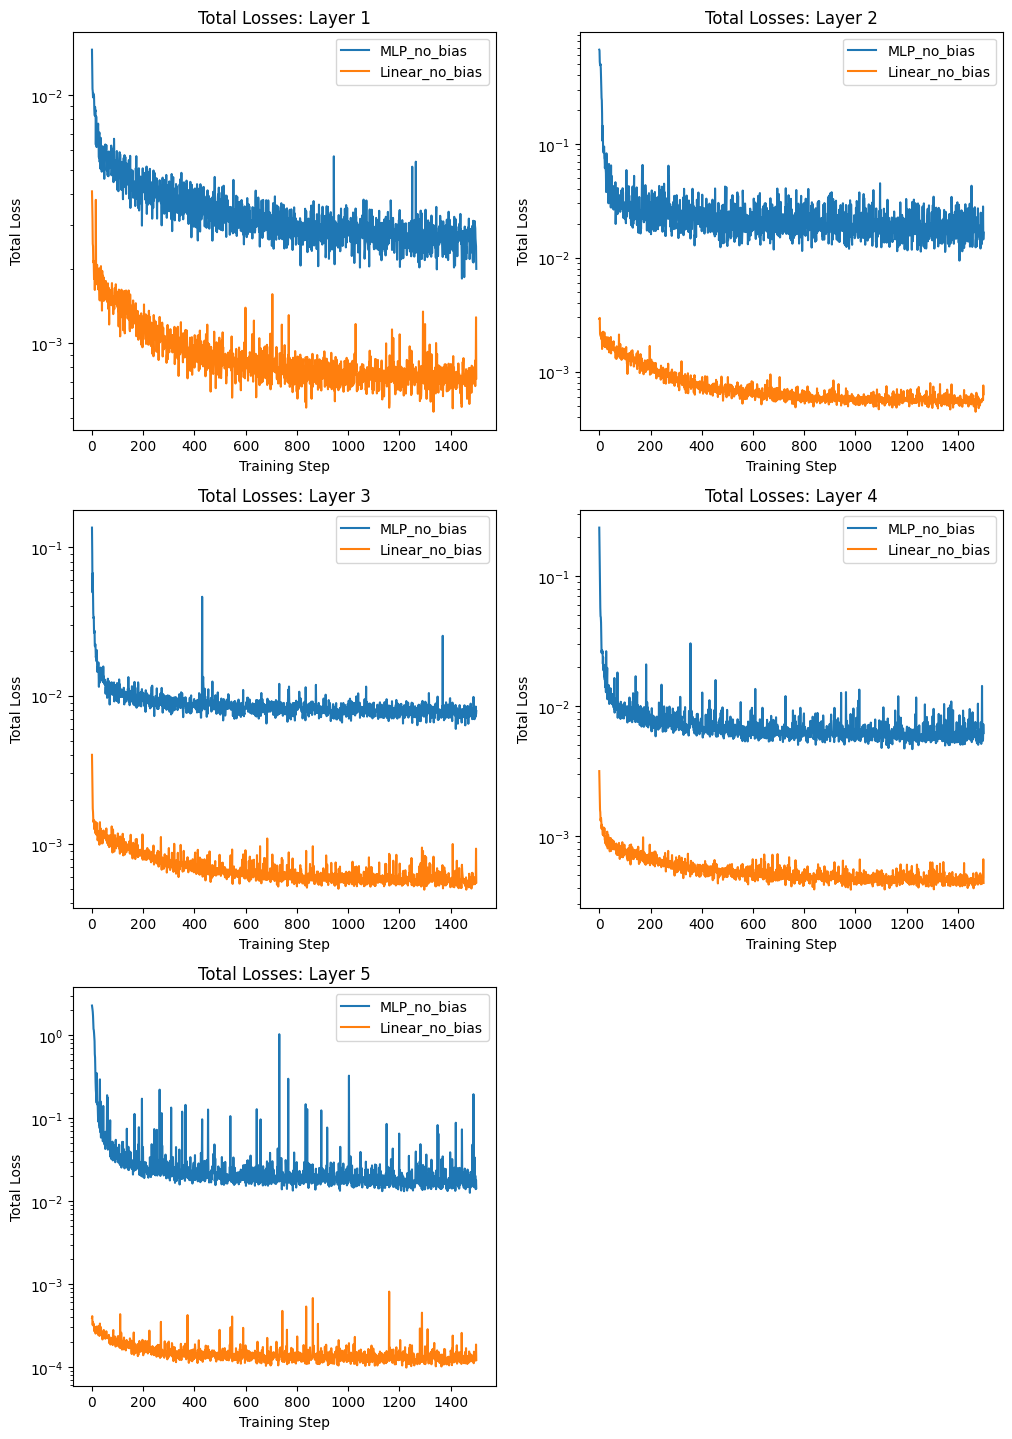

In [51]:
# Plot training curve for total loss
# Plot both losses
import matplotlib.pyplot as plt

num_columns = 2  # Two columns: one for each type of loss
num_rows = num_layers  # One row for each layer

plt.figure(figsize=(12, 6 * num_rows))  # Adjust the size as needed

for layer in range(num_layers):
    plt.subplot(num_rows, num_columns, layer + 1)
    plt.title(f"Total Losses: Layer {layer+1}")
    # plt.plot(mlp_losses_no_bias[layer][0][::2])
    # plt.plot(linear_losses_no_bias[layer][0][::2])
    plt.plot(mlp_losses_no_bias_mse[layer][0][::2])
    plt.plot(linear_losses_no_bias_mse[layer][0][::2])
    # plt.plot(mlp_losses_no_bias_l1[layer][0][::2])
    # plt.plot(linear_losses_no_bias_l1[layer][0][::2])
    # if(layer ==2):
    #     # set max y to 0.05
    #     plt.ylim(0, 0.03)
    plt.legend(["MLP_no_bias", "Linear_no_bias"])
    plt.xlabel("Training Step")
    plt.ylabel("Total Loss")
    # y log
    plt.yscale('log')
plt.show()

In [72]:
# for i in range (100):
#     large_weights = (linear_weights_no_bias[0][0].linear.weight[i] > 0.0005).sum()
#     print(f"Large weights: {large_weights}")
for i in range (100):
    large_weights = (mlp_weights_no_bias[0][0].linear.weight[i] > 0.0004).sum()
    print(f"Large weights: {large_weights}")

Large weights: 19
Large weights: 112
Large weights: 36
Large weights: 6
Large weights: 16
Large weights: 9
Large weights: 12
Large weights: 5
Large weights: 2
Large weights: 6
Large weights: 4
Large weights: 21
Large weights: 6
Large weights: 5
Large weights: 8
Large weights: 106
Large weights: 8
Large weights: 8
Large weights: 9
Large weights: 7
Large weights: 332
Large weights: 6
Large weights: 39
Large weights: 7
Large weights: 55
Large weights: 24
Large weights: 86
Large weights: 35
Large weights: 1
Large weights: 279
Large weights: 8
Large weights: 42
Large weights: 10
Large weights: 328
Large weights: 7
Large weights: 374
Large weights: 9
Large weights: 3
Large weights: 7
Large weights: 10
Large weights: 9
Large weights: 16
Large weights: 5
Large weights: 7
Large weights: 4
Large weights: 19
Large weights: 8
Large weights: 6
Large weights: 5
Large weights: 49
Large weights: 126
Large weights: 8
Large weights: 8
Large weights: 7
Large weights: 5
Large weights: 12
Large weights: 4


In [27]:
# Save the sparse weight models
dir = "sparse_weights"
for layer in range(num_layers):
    torch.save(mlp_weights_no_bias[layer][0], f"{dir}/mlp_weights_no_bias_{layer}.pt")
    torch.save(linear_weights_no_bias[layer][0], f"{dir}/linear_weights_no_bias_{layer}.pt")

In [47]:
linear_losses_no_bias[3][0][-1]

0.5426863431930542

## Sweep batch-size

In [14]:
# Let's just think about this for 1 layer
# If we're doing 10-different l1 alpha terms, then we have 10 different sparse weights
mlp_weights_no_bias = []
linear_weights_no_bias = []

mlp_optimizers_no_bias = []
linear_optimizers_no_bias = []
batch_sizes = 4
for layer in range(num_layers): # This is per layer
    num_linear_features = linear_features[layer].sum()
    num_mlp_features = mlp_features[layer].sum()
    mlp_weights_no_bias.append([])
    linear_weights_no_bias.append([])
    mlp_optimizers_no_bias.append([])
    linear_optimizers_no_bias.append([])
    for batch_sizes_ind in range(batch_sizes):
        mlp_weights_no_bias[-1].append(mlp_no_bias(num_features, output_size=num_mlp_features))
        mlp_optimizers_no_bias[-1].append(Adam(mlp_weights_no_bias[-1][-1].parameters(), lr=1e-3))
        linear_weights_no_bias[-1].append(linear_no_bias(num_features, output_size=num_linear_features))
        linear_optimizers_no_bias[-1].append(Adam(linear_weights_no_bias[-1][-1].parameters(), lr=1e-3))

In [19]:
linear_weights_no_bias[0]

[linear_no_bias(
   (linear): Linear(in_features=3072, out_features=853, bias=False)
 ),
 linear_no_bias(
   (linear): Linear(in_features=3072, out_features=853, bias=False)
 ),
 linear_no_bias(
   (linear): Linear(in_features=3072, out_features=853, bias=False)
 ),
 linear_no_bias(
   (linear): Linear(in_features=3072, out_features=853, bias=False)
 )]

In [24]:

def train_sparse_model_batch_size(model, dataset, device, sparse_weights, autoencoders, cache_names, optimizers, batch_size_lists, feature_ind, l1_alpha = 8e-4):
    mse = nn.MSELoss()
    losses = [[[] for _ in range(len(l1_alphas))] for _ in range(len(sparse_weights))]
    losses_mse = [[[] for _ in range(len(l1_alphas))] for _ in range(len(sparse_weights))]
    losses_l1 = [[[] for _ in range(len(l1_alphas))] for _ in range(len(sparse_weights))]
    
    # with dataset.formatted_as("pt"):
    #     dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for i, batch in enumerate(tqdm(dataset)):
        batch = batch["input_ids"].to(device)
        with torch.no_grad():
            with TraceDict(model, cache_names) as ret:
                _ = model(batch)
        
        for cache_name_ind in range(len(cache_names) // 2):
            with torch.no_grad():
                input_cache_name = cache_names[cache_name_ind * 2]
                output_cache_name = cache_names[cache_name_ind * 2 + 1]
                input_autoencoder = autoencoders[cache_name_ind * 2]
                output_autoencoder = autoencoders[cache_name_ind * 2 + 1]
                input_activations = ret[input_cache_name].output
                output_activations = ret[output_cache_name].output

                if isinstance(input_activations, tuple):
                    input_activations = input_activations[0]
                if isinstance(output_activations, tuple):
                    output_activations = output_activations[0]

                input_internal_activations = rearrange(input_activations, "b s n -> (b s) n")
                output_internal_activations = rearrange(output_activations, "b s n -> (b s) n")

                input_internal_activations = input_autoencoder.encode(input_internal_activations)
                output_internal_activations = output_autoencoder.encode(output_internal_activations)

            for batch_ind, batch_size in enumerate(batch_size_lists):
                # print(f"len of sparseweights: {len(sparse_weights[cache_name_ind])}")
                # print(f"batch ind: {batch_ind}")
                sparse_weight = sparse_weights[cache_name_ind][batch_ind].to(device)

                # Find ind of alive features & selected features (linear or MLP features)
                alive_features = alive_features_ind[cache_name_ind].nonzero(as_tuple=True)[0]
                alive_and_selected_features = alive_features[feature_ind[cache_name_ind]].to(device)
                # Split the batch (input/output_internal_activations) into batch_size amount of chunks
                batched_input_internal_activations = torch.split(input_internal_activations, batch_size, dim=0)
                batched_output_internal_activations = torch.split(output_internal_activations, batch_size, dim=0)
                for b_ind in range(batch_size):
                    x_hat = sparse_weight(batched_input_internal_activations[b_ind])

                    indexed_x_hat = x_hat
                    indexed_output_internal_activations = batched_output_internal_activations[b_ind].index_select(dim=1, index=alive_and_selected_features)
                    
                    # Divide MSE_loss by normalization factor
                    mse_loss = mse(indexed_x_hat, indexed_output_internal_activations) / normalization_per_layer[cache_name_ind]
                    l1_loss = torch.norm(sparse_weight.linear.weight, dim=1, p=1).mean()
                    # check if sparse_weight.linear2 exists
                    if hasattr(sparse_weight, "linear2"):
                        l1_loss += torch.norm(sparse_weight.linear2.weight, dim=1, p=1).mean()
                        l1_loss /= 2
                    unweighted_loss = mse_loss + l1_loss
                    loss = mse_loss + l1_alpha * l1_loss

                    loss.backward()
                    optimizers[cache_name_ind][batch_ind].step()
                    optimizers[cache_name_ind][batch_ind].zero_grad()
                losses[cache_name_ind][batch_ind].append(unweighted_loss.item())
                losses_mse[cache_name_ind][batch_ind].append(mse_loss.item())
                losses_l1[cache_name_ind][batch_ind].append(l1_loss.item())

                sparse_weight = sparse_weight.to("cpu")
                if i % 100 == 0:
                    print(f"Layers: {cache_name_ind} | l1 alpha MSE Loss: {mse_loss.item()} | L1 Loss: {l1_loss.item()}")

                del x_hat, indexed_x_hat, indexed_output_internal_activations, loss, l1_loss, mse_loss, unweighted_loss, alive_and_selected_features
                torch.cuda.empty_cache()
        if i > 100:
            # Stop training after 1000 batches
            break
    return losses, losses_mse, losses_l1
batch_size_lists = [1,2,4,8]
linear_losses_no_bias, linear_losses_no_bias_mse, linear_losses_no_bias_l1 = train_sparse_model_batch_size(model, dataset, device, linear_weights_no_bias, autoencoders, cache_names, linear_optimizers_no_bias, batch_size_lists, linear_features)
mlp_losses_no_bias, mlp_losses_no_bias_mse, mlp_losses_no_bias_l1 = train_sparse_model_batch_size(model, dataset, device, mlp_weights_no_bias, autoencoders, cache_names, mlp_optimizers_no_bias, batch_size_lists, mlp_features)

  0%|          | 0/10963 [00:00<?, ?it/s]

Layers: 0 | l1 alpha MSE Loss: 0.01108487043529749 | L1 Loss: 16.406333923339844
Layers: 0 | l1 alpha MSE Loss: 0.0072320373728871346 | L1 Loss: 14.048239707946777
Layers: 0 | l1 alpha MSE Loss: 0.0020126362796872854 | L1 Loss: 12.339141845703125
Layers: 0 | l1 alpha MSE Loss: 0.009344893507659435 | L1 Loss: 11.838696479797363
Layers: 1 | l1 alpha MSE Loss: 0.0035510286688804626 | L1 Loss: 27.70962905883789
Layers: 1 | l1 alpha MSE Loss: 0.0020851348526775837 | L1 Loss: 24.861005783081055
Layers: 1 | l1 alpha MSE Loss: 0.0062055205926299095 | L1 Loss: 19.660966873168945
Layers: 1 | l1 alpha MSE Loss: 0.004365518223494291 | L1 Loss: 11.681697845458984
Layers: 2 | l1 alpha MSE Loss: 0.13593453168869019 | L1 Loss: 27.70911979675293
Layers: 2 | l1 alpha MSE Loss: 0.0008077995735220611 | L1 Loss: 24.885446548461914
Layers: 2 | l1 alpha MSE Loss: 0.003832042682915926 | L1 Loss: 19.810791015625
Layers: 2 | l1 alpha MSE Loss: 0.002782099414616823 | L1 Loss: 11.939117431640625
Layers: 3 | l1 al

  0%|          | 1/10963 [00:00<1:37:14,  1.88it/s]

Layers: 4 | l1 alpha MSE Loss: 0.00012494964175857604 | L1 Loss: 19.63352394104004
Layers: 4 | l1 alpha MSE Loss: 0.00017453737382311374 | L1 Loss: 11.440549850463867


  1%|          | 100/10963 [00:41<1:19:26,  2.28it/s]

Layers: 0 | l1 alpha MSE Loss: 0.01148004736751318 | L1 Loss: 10.907217025756836
Layers: 0 | l1 alpha MSE Loss: 0.0001482250081608072 | L1 Loss: 10.433944702148438
Layers: 0 | l1 alpha MSE Loss: 0.0012853475054726005 | L1 Loss: 9.779388427734375
Layers: 0 | l1 alpha MSE Loss: 0.0033413521014153957 | L1 Loss: 8.776857376098633
Layers: 1 | l1 alpha MSE Loss: 0.000371765490854159 | L1 Loss: 0.9866786599159241
Layers: 1 | l1 alpha MSE Loss: 0.0012366654118523002 | L1 Loss: 0.6081542372703552
Layers: 1 | l1 alpha MSE Loss: 0.0004279441200196743 | L1 Loss: 0.5737454891204834
Layers: 1 | l1 alpha MSE Loss: 0.0023512302432209253 | L1 Loss: 0.5838077664375305
Layers: 2 | l1 alpha MSE Loss: 0.004182395990937948 | L1 Loss: 1.3501023054122925
Layers: 2 | l1 alpha MSE Loss: 0.0013818911975249648 | L1 Loss: 0.6858962774276733
Layers: 2 | l1 alpha MSE Loss: 0.0009942067554220557 | L1 Loss: 0.6465616822242737
Layers: 2 | l1 alpha MSE Loss: 0.0009721997193992138 | L1 Loss: 0.6518599987030029
Layers: 3 

  1%|          | 101/10963 [00:42<1:15:14,  2.41it/s]

Layers: 3 | l1 alpha MSE Loss: 0.0006381093407981098 | L1 Loss: 0.49096494913101196
Layers: 3 | l1 alpha MSE Loss: 0.0010913248406723142 | L1 Loss: 0.4924597144126892
Layers: 4 | l1 alpha MSE Loss: 0.013101235963404179 | L1 Loss: 0.4127342700958252
Layers: 4 | l1 alpha MSE Loss: 0.00029025247204117477 | L1 Loss: 0.38380274176597595
Layers: 4 | l1 alpha MSE Loss: 0.0003766260633710772 | L1 Loss: 0.3801612854003906
Layers: 4 | l1 alpha MSE Loss: 0.00013140718510840088 | L1 Loss: 0.3779260516166687


  0%|          | 0/10963 [00:00<?, ?it/s]

Layers: 0 | l1 alpha MSE Loss: 0.16319960355758667 | L1 Loss: 27.716306686401367
Layers: 0 | l1 alpha MSE Loss: 0.01577700302004814 | L1 Loss: 25.64874267578125
Layers: 0 | l1 alpha MSE Loss: 0.0018990858225151896 | L1 Loss: 22.068191528320312
Layers: 0 | l1 alpha MSE Loss: 0.009333942085504532 | L1 Loss: 15.491870880126953
Layers: 1 | l1 alpha MSE Loss: 33.485992431640625 | L1 Loss: 27.69315528869629
Layers: 1 | l1 alpha MSE Loss: 0.020819811150431633 | L1 Loss: 25.687313079833984
Layers: 1 | l1 alpha MSE Loss: 0.04993215203285217 | L1 Loss: 22.296546936035156
Layers: 1 | l1 alpha MSE Loss: 0.05541082099080086 | L1 Loss: 17.264114379882812
Layers: 2 | l1 alpha MSE Loss: 2.2771458625793457 | L1 Loss: 27.662487030029297
Layers: 2 | l1 alpha MSE Loss: 0.04349406063556671 | L1 Loss: 25.71468734741211
Layers: 2 | l1 alpha MSE Loss: 0.05708504095673561 | L1 Loss: 22.483768463134766
Layers: 2 | l1 alpha MSE Loss: 0.05565192177891731 | L1 Loss: 17.82221221923828
Layers: 3 | l1 alpha MSE Loss:

  0%|          | 1/10963 [00:01<3:46:29,  1.24s/it]

Layers: 4 | l1 alpha MSE Loss: 1.7191894054412842 | L1 Loss: 14.76616096496582


  1%|          | 100/10963 [02:01<4:08:57,  1.38s/it]

Layers: 0 | l1 alpha MSE Loss: 0.018970543518662453 | L1 Loss: 5.650140762329102
Layers: 0 | l1 alpha MSE Loss: 0.004428334999829531 | L1 Loss: 4.917581081390381
Layers: 0 | l1 alpha MSE Loss: 0.0451621413230896 | L1 Loss: 4.817112922668457
Layers: 0 | l1 alpha MSE Loss: 0.0006021808367222548 | L1 Loss: 4.370416641235352
Layers: 1 | l1 alpha MSE Loss: 0.0664447620511055 | L1 Loss: 11.791213035583496
Layers: 1 | l1 alpha MSE Loss: 0.27335211634635925 | L1 Loss: 15.092637062072754
Layers: 1 | l1 alpha MSE Loss: 1.1110835075378418 | L1 Loss: 17.98584747314453
Layers: 1 | l1 alpha MSE Loss: 0.01055885013192892 | L1 Loss: 18.779285430908203
Layers: 2 | l1 alpha MSE Loss: 0.02451123669743538 | L1 Loss: 7.997378826141357
Layers: 2 | l1 alpha MSE Loss: 0.014653343707323074 | L1 Loss: 8.486013412475586
Layers: 2 | l1 alpha MSE Loss: 0.04060237854719162 | L1 Loss: 10.007165908813477
Layers: 2 | l1 alpha MSE Loss: 0.007704219780862331 | L1 Loss: 9.779840469360352
Layers: 3 | l1 alpha MSE Loss: 0.

  1%|          | 101/10963 [02:02<4:17:13,  1.42s/it]

Layers: 4 | l1 alpha MSE Loss: 1.088895559310913 | L1 Loss: 18.488967895507812


  1%|          | 101/10963 [02:04<3:42:20,  1.23s/it]


## Sweep over MLP

In [16]:
    
class mlp_no_bias(nn.Module):
    def __init__(self, input_size, hidden_layer_size=None):
        super().__init__()
        if hidden_layer_size is None:
            hidden_layer_size = input_size
        self.linear = nn.Linear(input_size, hidden_layer_size, bias=False)
        self.linear2 = nn.Linear(hidden_layer_size, input_size, bias=False)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

mlp_weights_no_bias = []

mlp_optimizers_no_bias = []
hidden_layer_sizes = 13
for auto_ind in range(len(autoencoders)//2): # This is per layer
    mlp_weights_no_bias.append([])
    mlp_optimizers_no_bias.append([])
    for hidd_layer_s in range(hidden_layer_sizes):
        mlp_weights_no_bias[-1].append(mlp_no_bias(num_features, 2**(hidd_layer_s+1)))
        mlp_optimizers_no_bias[-1].append(Adam(mlp_weights_no_bias[-1][-1].parameters(), lr=1e-3))

In [17]:
def train_sparse_model_hidden_unit(model, dataset, device, sparse_weights, autoencoders, cache_names, optimizers):
    mse = nn.MSELoss()
    batch_size = 32
    hidden_unit_models = len(sparse_weights[0])
    losses = [[[] for _ in range(hidden_unit_models)] for _ in range(len(sparse_weights))]
    
    # with dataset.formatted_as("pt"):
    #     dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for i, batch in enumerate(tqdm(dataset)):
        batch = batch["input_ids"].to(device)
        with torch.no_grad():
            with TraceDict(model, cache_names) as ret:
                _ = model(batch)
        
        for cache_name_ind in range(len(cache_names) // 2):
            with torch.no_grad():
                input_cache_name = cache_names[cache_name_ind * 2]
                output_cache_name = cache_names[cache_name_ind * 2 + 1]
                input_autoencoder = autoencoders[cache_name_ind * 2]
                output_autoencoder = autoencoders[cache_name_ind * 2 + 1]
                input_activations = ret[input_cache_name].output
                output_activations = ret[output_cache_name].output

                if isinstance(input_activations, tuple):
                    input_activations = input_activations[0]
                if isinstance(output_activations, tuple):
                    output_activations = output_activations[0]

                input_internal_activations = rearrange(input_activations, "b s n -> (b s) n")
                output_internal_activations = rearrange(output_activations, "b s n -> (b s) n")

                input_internal_activations = input_autoencoder.encode(input_internal_activations)
                output_internal_activations = output_autoencoder.encode(output_internal_activations)

            for hidden_unit_m in range(hidden_unit_models):
                sparse_weight = sparse_weights[cache_name_ind][hidden_unit_m].to(device)
                x_hat = sparse_weight(input_internal_activations)

                # loss = mse(x_hat, output_internal_activations)
                current_alive_features_ind = alive_features_ind[cache_name_ind].nonzero(as_tuple=True)[0].to(device)
                indexed_x_hat = x_hat.index_select(dim=1, index=current_alive_features_ind)
                indexed_output_internal_activations = output_internal_activations.index_select(dim=1, index=current_alive_features_ind)
                
                mse_loss = mse(indexed_x_hat, indexed_output_internal_activations)
                loss = mse_loss

                loss.backward()
                optimizers[cache_name_ind][hidden_unit_m].step()
                optimizers[cache_name_ind][hidden_unit_m].zero_grad()
                losses[cache_name_ind][hidden_unit_m].append(loss.item())

                sparse_weight = sparse_weight.to("cpu")
                if i % 300 == 0:
                    print(f"Layers: {cache_name_ind} | MSE Loss: {loss.item()}")

                del x_hat, indexed_x_hat, indexed_output_internal_activations, loss, current_alive_features_ind, mse_loss
                torch.cuda.empty_cache()

        if i > 300:
            # Stop training after 1000 batches
            break
    return losses
mlp_losses_no_bias = train_sparse_model_hidden_unit(model, dataset, device, mlp_weights_no_bias, autoencoders, cache_names, mlp_optimizers_no_bias)

  0%|          | 0/10963 [00:00<?, ?it/s]

Layers: 0 | MSE Loss: 0.005501554347574711
Layers: 0 | MSE Loss: 0.00553678534924984
Layers: 0 | MSE Loss: 0.005442761350423098
Layers: 0 | MSE Loss: 0.005443949718028307
Layers: 0 | MSE Loss: 0.0054717641323804855
Layers: 0 | MSE Loss: 0.00543338805437088
Layers: 0 | MSE Loss: 0.005409144330769777
Layers: 0 | MSE Loss: 0.005405251402407885
Layers: 0 | MSE Loss: 0.005431877449154854
Layers: 0 | MSE Loss: 0.005403609946370125
Layers: 0 | MSE Loss: 0.0054214466363191605
Layers: 0 | MSE Loss: 0.005428903270512819
Layers: 0 | MSE Loss: 0.005418367218226194
Layers: 1 | MSE Loss: 0.06880893558263779
Layers: 1 | MSE Loss: 0.06885495781898499
Layers: 1 | MSE Loss: 0.06853997707366943
Layers: 1 | MSE Loss: 0.06845316290855408
Layers: 1 | MSE Loss: 0.06851335614919662
Layers: 1 | MSE Loss: 0.0686269998550415
Layers: 1 | MSE Loss: 0.06857927143573761
Layers: 1 | MSE Loss: 0.0686480700969696
Layers: 1 | MSE Loss: 0.06843666732311249
Layers: 1 | MSE Loss: 0.06871131807565689
Layers: 1 | MSE Loss: 0

  0%|          | 1/10963 [00:02<8:23:12,  2.75s/it]

Layers: 4 | MSE Loss: 4.555083751678467


  3%|▎         | 300/10963 [13:46<8:11:05,  2.76s/it] 

Layers: 0 | MSE Loss: 0.004248362500220537
Layers: 0 | MSE Loss: 0.004250658210366964
Layers: 0 | MSE Loss: 0.0042420318350195885
Layers: 0 | MSE Loss: 0.00382217182777822
Layers: 0 | MSE Loss: 0.0032627990003675222
Layers: 0 | MSE Loss: 0.002748209750279784
Layers: 0 | MSE Loss: 0.002356917131692171
Layers: 0 | MSE Loss: 0.0019626086577773094
Layers: 0 | MSE Loss: 0.0015897859120741487
Layers: 0 | MSE Loss: 0.00132092391140759
Layers: 0 | MSE Loss: 0.001136928447522223
Layers: 0 | MSE Loss: 0.0010089885909110308
Layers: 0 | MSE Loss: 0.001014913315884769
Layers: 1 | MSE Loss: 0.05118892341852188
Layers: 1 | MSE Loss: 0.049422748386859894
Layers: 1 | MSE Loss: 0.01966453343629837
Layers: 1 | MSE Loss: 0.01270791795104742
Layers: 1 | MSE Loss: 0.009349728003144264
Layers: 1 | MSE Loss: 0.008106575347483158
Layers: 1 | MSE Loss: 0.006919429171830416
Layers: 1 | MSE Loss: 0.005623080767691135
Layers: 1 | MSE Loss: 0.004562114365398884
Layers: 1 | MSE Loss: 0.003838918637484312
Layers: 1 |

  3%|▎         | 301/10963 [13:49<8:10:50,  2.76s/it]

Layers: 4 | MSE Loss: 0.06059036776423454


  3%|▎         | 301/10963 [13:52<8:11:25,  2.77s/it]


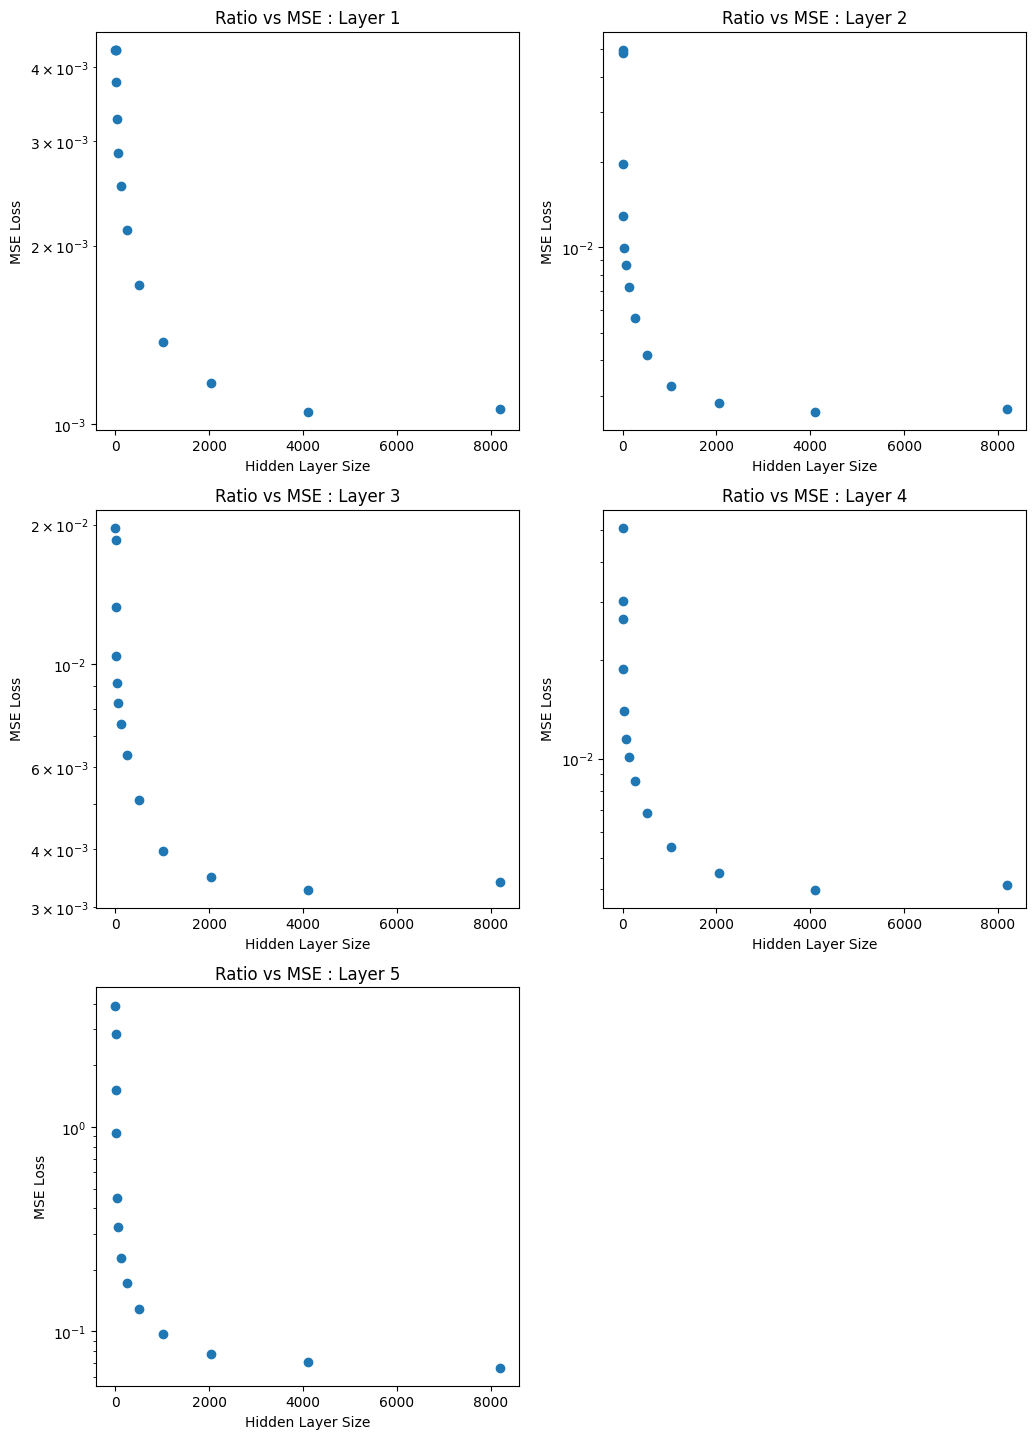

In [20]:
# Plot both losses, just the last value for both MSE and L1
import matplotlib.pyplot as plt

num_layers = len(mlp_losses_no_bias)
num_columns = 2  # Two columns: one for each type of loss
num_rows = num_layers  # One row for each layer

hidden_layer_sizes
mlp_losses_last = np.zeros((num_layers, hidden_layer_sizes))
for layer in range(num_layers):
    for hidden_layer_s in range(hidden_layer_sizes):
        mlp_losses_last[layer, hidden_layer_s] = mlp_losses_no_bias[layer][hidden_layer_s][-1]

plt.figure(figsize=(12, 6 * num_rows))  # Adjust the size as needed
ratios = [2**(i+1) for i in range(hidden_layer_sizes)]
for layer in range(num_layers):
    # Subplot for MSE Loss
    plt.subplot(num_rows, num_columns, layer+1)
    plt.title(f"Ratio vs MSE : Layer {layer+1}")
    # Grabe the last value of MSE and L1
    mlp_l1_loss = mlp_losses_last[layer]
    # Plot
    plt.plot(ratios, mlp_l1_loss, 'o')
    plt.yscale('log')
    # plt.xscale('log')
    # plt.legend()
    plt.ylabel("MSE Loss")
    plt.xlabel("Hidden Layer Size")
plt.show()

In [13]:
ratios

[2, 4, 8, 16, 32, 64, 128, 256]

In [31]:
len(mlp_losses_no_bias[0][0])

5

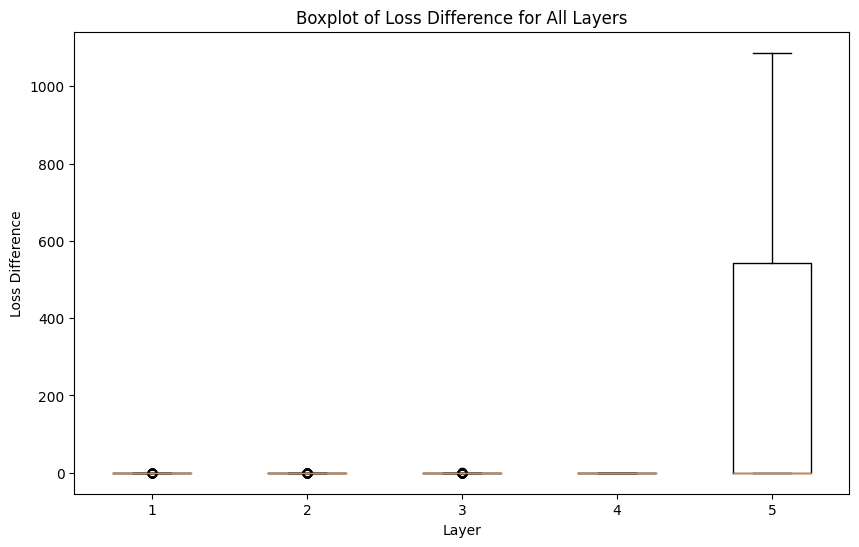

In [19]:
import matplotlib.pyplot as plt

# Collect all loss_diff data for each layer into a list
all_layers_loss_diff = [loss_diff[layer] for layer in range(len(loss_diff))]

plt.figure(figsize=(10, 6))  # Adjust the size as needed
plt.boxplot(all_layers_loss_diff)
plt.title("Boxplot of Loss Difference for All Layers")
plt.xlabel("Layer")
plt.ylabel("Loss Difference")

plt.show()

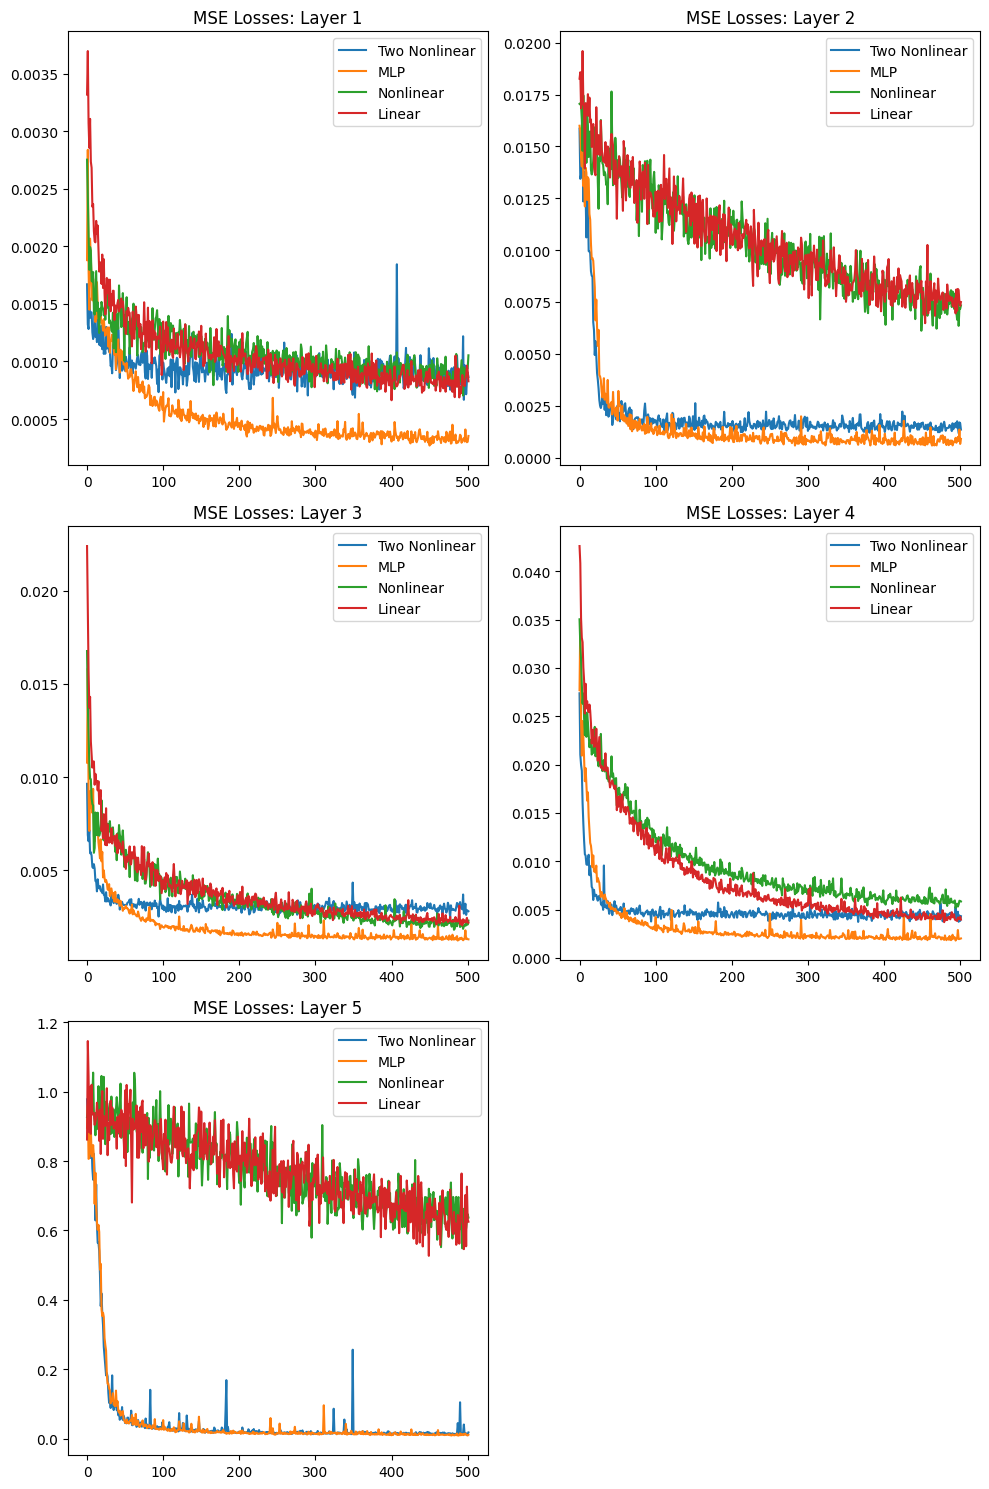

In [15]:
import matplotlib.pyplot as plt

num_layers = len(two_nonlinear_losses)
num_columns = 2  # You can adjust this based on how many plots you want per row
num_rows = (num_layers + num_columns - 1) // num_columns  # Calculate the number of rows needed

plt.figure(figsize=(10, 5 * num_rows))  # Adjust the size as needed

for layer in range(num_layers):
    plt.subplot(num_rows, num_columns, layer + 1)  # Create a subplot for each layer
    plt.title(f"MSE Losses: Layer {layer+1}")
    plt.plot(two_nonlinear_losses[layer], label="Two Nonlinear")
    plt.plot(mlp_losses[layer], label="MLP")
    plt.plot(nonlinear_losses[layer], label="Nonlinear")
    plt.plot(linear_losses[layer], label="Linear")
    plt.legend()

plt.tight_layout()
plt.show()


In [24]:
nonlinear_losses, linear_loss

(array([0.00114306, 0.02376839, 0.00199088, 0.00503561, 0.70069301]),
 array([0.00112041, 0.02399791, 0.00216295, 0.00460967, 0.70566905]))

In [53]:
from baukit import TraceDict
mse = nn.MSELoss()
l1_alpha = 1e-3
datapoints = dataset.num_rows
batch_size = 32
losses = np.zeros(len(sparse_weights))
with dataset.formatted_as("pt"):
    dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for i, batch in enumerate(dl):
        batch = batch.to(device)
        with torch.no_grad():
            # Get LLM intermediate activations
            with TraceDict(model, cache_names) as ret:
                _ = model(batch)
        # # Get every 2 cache names (since they're matched up)
        for cache_name_ind in range(len(cache_names)//2):
            sparse_weight = sparse_weights[cache_name_ind]

            input_cache_name = cache_names[(cache_name_ind*2)]
            output_cache_name = cache_names[(cache_name_ind*2)+1]
            input_autoencoder = autoencoders[(cache_name_ind*2)]
            output_autoencoder = autoencoders[(cache_name_ind*2)+1]
            input_activations = ret[input_cache_name].output
            output_activations = ret[output_cache_name].output
            # check if instance tuple ie a layer output
            if(isinstance(input_activations, tuple)):
                input_activations = input_activations[0]
            if(isinstance(output_activations, tuple)):
                output_activations = output_activations[0]
            # Rearrange to (batch_size*seq_length, num_features)
            input_internal_activations = rearrange(input_activations, "b s n -> (b s) n" )
            output_internal_activations = rearrange(output_activations, "b s n -> (b s) n" )
            # Encode
            input_internal_activations = input_autoencoder.encode(input_internal_activations)
            output_internal_activations = output_autoencoder.encode(output_internal_activations)
            # Encode
            x_hat = sparse_weights[cache_name_ind](input_internal_activations)
            # Get loss
            loss = mse(x_hat, output_internal_activations)
            l1_loss = torch.norm(sparse_weight.linear.weight, dim=1, p=1).mean()
            # loss += l1_alpha*l1_loss
            # Backprop
            loss.backward()
            optimizers[cache_name_ind].step()
            optimizers[cache_name_ind].zero_grad()
            losses[cache_name_ind] = loss.item()
            if(i%50==0):
                print(f"Layers: {cache_name_ind} |  MSE Loss: {loss.item()} | L1 Loss: {l1_loss.item()}")


Layers: 0 |  MSE Loss: 0.0032902932725846767 | L1 Loss: 27.721176147460938
Layers: 1 |  MSE Loss: 0.045880552381277084 | L1 Loss: 27.712087631225586
Layers: 2 |  MSE Loss: 0.02548954077064991 | L1 Loss: 27.71087646484375
Layers: 3 |  MSE Loss: 0.0651974007487297 | L1 Loss: 27.717008590698242
Layers: 4 |  MSE Loss: 0.8611162900924683 | L1 Loss: 27.709190368652344
Layers: 0 |  MSE Loss: 0.001719774678349495 | L1 Loss: 24.83885955810547
Layers: 1 |  MSE Loss: 0.038391195237636566 | L1 Loss: 26.483190536499023
Layers: 2 |  MSE Loss: 0.0042221806943416595 | L1 Loss: 28.59328269958496
Layers: 3 |  MSE Loss: 0.02699713036417961 | L1 Loss: 28.991947174072266
Layers: 4 |  MSE Loss: 0.8554728031158447 | L1 Loss: 29.95911979675293
Layers: 0 |  MSE Loss: 0.0017383686499670148 | L1 Loss: 24.861730575561523
Layers: 1 |  MSE Loss: 0.035102322697639465 | L1 Loss: 26.954181671142578
Layers: 2 |  MSE Loss: 0.0031695878133177757 | L1 Loss: 29.906362533569336
Layers: 3 |  MSE Loss: 0.018583638593554497 | 

In [55]:
losses_mlp, losses

# See if the top weights have high cosine similarity between the two

In [13]:
indices = (Sparse_nonlinear.linear.weight > 0.1).nonzero()
# for f_out, f_in in indices:
    # Find the cosine similarity between these two vectors

dict_in = autoencoders[0].get_learned_dict()
dict_out = autoencoders[1].get_learned_dict()


In [1]:
# f2 = ReLU(w*f1 + b)
'''
d1= [f_0, f_1]

w = [w00, w01]
    [w10, w11]

f2 = [f_0*w00 + f_1*w10, f_0*w01 +f_1*w11]
'''

'\nd1= [f_0, f_1]\n\nw = [w00, w01]\n    [w10, w11]\n\nf2 = [f_0*w00 + f_1*w10, f_0*w01 +f_1*w11]\n'

In [24]:
squished = Sparse_nonlinear.linear.weight.detach().flatten()
top_val, top_ind = torch.topk(squished, 10)
row_ind = top_ind//num_features
col_ind = top_ind%num_features
# Row is output feature index
# Col is input feature index
top_val, row_ind, col_ind

(tensor([0.3108, 0.3100, 0.3035, 0.3032, 0.3001, 0.2986, 0.2986, 0.2979, 0.2974,
         0.2940], device='cuda:0'),
 tensor([2390, 2863, 2390, 1224, 2863, 1224, 1582, 2863, 1582, 1582],
        device='cuda:0'),
 tensor([3028, 3028,  247,  247,  887,  887,  887, 1904,  247,   67],
        device='cuda:0'))

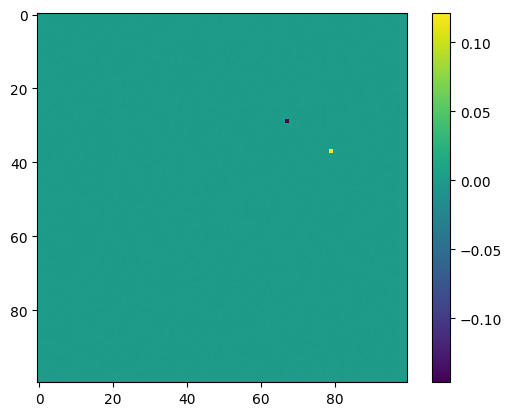

In [25]:
# Plot weight matrix as image
import matplotlib.pyplot as plt
plt.imshow(Sparse_nonlinear.linear.weight[:100,:100].detach().cpu())
plt.colorbar()
plt.show()

In [33]:
threshold_pos = 0.1
threshold_neg = -0.1
total_weights = Sparse_nonlinear.linear.weight.numel()
(Sparse_nonlinear.linear.weight > threshold_pos).count_nonzero() / total_weights, (Sparse_nonlinear.linear.weight < threshold_neg).count_nonzero() / total_weights, total_weights

(tensor(0.0002, device='cuda:0'), tensor(0.0001, device='cuda:0'), 9437184)

In [35]:
indices = (Sparse_nonlinear.linear.weight > 0.1).nonzero()
indices, Sparse_nonlinear.linear.weight[indices[:,0], indices[:,1]]

(tensor([[   1, 2191],
         [  11,  596],
         [  11, 1184],
         ...,
         [3059, 2127],
         [3059, 3066],
         [3065, 2497]], device='cuda:0'),
 tensor([0.1686, 0.1715, 0.1995,  ..., 0.2472, 0.1418, 0.1529], device='cuda:0',
        grad_fn=<IndexBackward0>))

In [38]:
indices[:10]

tensor([[   1, 2191],
        [  11,  596],
        [  11, 1184],
        [  11, 2676],
        [  14, 2468],
        [  19, 1166],
        [  20,  719],
        [  28,  232],
        [  28,  662],
        [  29, 1404]], device='cuda:0')

In [39]:
indices[10:20]

tensor([[  31, 2115],
        [  31, 2399],
        [  31, 3014],
        [  34, 2422],
        [  37,   79],
        [  37, 1885],
        [  89, 1323],
        [ 103,  837],
        [ 103, 2310],
        [ 105, 1565]], device='cuda:0')

In [40]:
indices[20:30]

tensor([[ 105, 2002],
        [ 105, 2697],
        [ 106,   67],
        [ 106,  146],
        [ 106,  189],
        [ 106,  247],
        [ 106,  330],
        [ 106,  344],
        [ 106,  458],
        [ 106,  690]], device='cuda:0')

In [14]:
f_ind = 1899
Sparse_nonlinear.linear.weight[:, f_ind].topk(5).values, Sparse_nonlinear.linear.weight[f_ind, :].topk(5).values

(tensor([0.0828, 0.0023, 0.0022, 0.0014, 0.0009], device='cuda:0',
        grad_fn=<TopkBackward0>),
 tensor([0.1980, 0.1734, 0.1371, 0.1282, 0.1280], device='cuda:0',
        grad_fn=<TopkBackward0>))

In [18]:
features = [11, 29, 203]
import matplotlib.pyplot as plt
for x in features:
    val = Sparse_nonlinear.linear.weight[x]
#     plt.hist(val.detach().cpu().numpy(), bins=50, label=f"Feature {x}")
    mean = val.mean()
    std = val.std()
    min = val.min()
    max = val.max()
    print(f"Feature {x}: mean: {mean}, std: {std}, min: {min}, max: {max}")
# plt.legend()
plt.show()

Feature 11: mean: 0.0001571535540279001, std: 0.00546741159632802, min: -0.10035543143749237, max: 0.16572602093219757
Feature 29: mean: -0.0004656702221836895, std: 0.011058892123401165, min: -0.2426990568637848, max: 0.15703199803829193
Feature 203: mean: 0.0017885728739202023, std: 0.03143875673413277, min: -0.22366595268249512, max: 0.2349885255098343


In [39]:
f_ind = 9
print("Dead Feature")
print(f"column: {Sparse_nonlinear.linear.weight[:, f_ind].topk(5).values}")
print(f"Row: { Sparse_nonlinear.linear.weight[f_ind, :].topk(5).values}")
    

Dead Feature
column: tensor([0.1078, 0.0246, 0.0006, 0.0006, 0.0006], device='cuda:0',
       grad_fn=<TopkBackward0>)
Row: tensor([0.0006, 0.0006, 0.0006, 0.0006, 0.0006], device='cuda:0',
       grad_fn=<TopkBackward0>)


In [31]:
# dictionary_activations[:100000].count_nonzero(0).count_nonzero(0)
dictionary_activations[:10000].count_nonzero(0).topk(10, largest=False), dictionary_activations[:10000].count_nonzero(0).topk(10, largest=True)

(torch.return_types.topk(
 values=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 indices=tensor([ 8,  9,  4,  7,  5,  3,  0, 10,  2,  6])),
 torch.return_types.topk(
 values=tensor([4094, 3426, 3297, 2861, 2722, 2140, 1370, 1369, 1354, 1084]),
 indices=tensor([1899,  203,  905,  260, 1773, 1191, 2863, 1224, 2390,  628])))

In [17]:
dictionary_activations.shape

torch.Size([297480, 3072])

In [9]:
from alpha_utils_interp import *
import os
# make features/ dir if not exist
save_path = "features/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
num_feature_datapoints = 10
dictionary_activations, tokens_for_each_datapoint = get_dictionary_activations(model, dataset, cache_name, max_seq_length, autoencoder, batch_size=32)

# features = [1,2,3,4,5,6,7,8,9,10]
# features = [5,6]
# features = None
num_features = 30
feature = 0
input_setting = "input_only"
for _ in range(num_features):
    # Check if feature is dead (<10 activations)
    dead_threshold = 10
    # if(dictionary_activations[:, current_feature].count_nonzero() < dead_threshold):
    while(dictionary_activations[:, feature].count_nonzero() < dead_threshold):
        print(f"Feature {feature} is dead")
        feature += 1
    uniform_indices = get_feature_indices(feature, dictionary_activations, k=num_feature_datapoints, setting="uniform")
    text_list, full_text, token_list, full_token_list, partial_activations, full_activations = get_feature_datapoints(uniform_indices, dictionary_activations[:, feature], tokenizer, max_seq_length, dataset)
    # get_token_statistics(feature, dictionary_activations[:, feature], dataset, tokenizer, max_seq_length, tokens_for_each_datapoint, save_location = save_path, num_unique_tokens=10)
    if(input_setting == "input_only"):
        # Calculate logit diffs on this feature for the full_token_list
        logit_diffs = ablate_feature_direction(model, full_token_list, cache_name, max_seq_length, autoencoder, feature = feature, batch_size=32, setting="sentences", model_type=model_type)
        # save_token_display(full_token_list, full_activations, tokenizer, path =f"{save_path}uniform_{feature}.png", logit_diffs = logit_diffs, model_type=model_type)
        save_token_display(full_token_list, full_activations, tokenizer, path =f"{save_path}uniform_{feature}.png", logit_diffs = logit_diffs, model_type=model_type, show=True)
        all_changed_activations = ablate_context_one_token_at_a_time(model, token_list, cache_name, autoencoder, feature, max_ablation_length=30)
        save_token_display(token_list, all_changed_activations, tokenizer, path =f"{save_path}ablate_context_{feature}.png", model_type=model_type, show=True)
    else:
        logit_diffs = ablate_feature_direction(model, dataset, cache_name, max_seq_length, autoencoder, feature = feature, batch_size=32, setting="dataset")
        _, _, _, full_token_list_ablated, _, full_activations_ablated = get_feature_datapoints(uniform_indices, logit_diffs, tokenizer, max_seq_length, dataset)
        get_token_statistics(feature, logit_diffs, dataset, tokenizer, max_seq_length, tokens_for_each_datapoint, save_location = save_path, setting="output", num_unique_tokens=10)
        save_token_display(full_token_list_ablated, full_activations, tokenizer, path =f"{save_path}uniform_{feature}.png", logit_diffs = full_activations_ablated)
    # if(ablate_context ==True):
    #     all_changed_activations = ablate_context_one_token_at_a_time(model, dataset, cache_name, autoencoder, feature, max_ablation_length=20)
    #     save_token_display(token_list, all_changed_activations, tokenizer, path =f"{save_path}ablate_context_{feature}.png", model_type=model_type, show=True)
    # combine_images(feature, setting=input_setting, ablate_context=ablate_context)
    feature += 1

100%|██████████| 310/310 [00:10<00:00, 29.77it/s]
/root/sparse_coding/alpha_utils_interp.py:349: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at ../aten/src/ATen/native/BucketizationUtils.h:33.)
  bins = torch.bucketize(best_feature_activations, bin_boundaries)


Feature 0 is dead


NameError: name 'model_type' is not defined

In [ ]:
Sparse_nonlinear.linear.weight[:, x].topk(10)

torch.return_types.topk(
values=tensor([0.0016, 0.0008, 0.0007, 0.0007, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0005], device='cuda:0', grad_fn=<TopkBackward0>),
indices=tensor([1899, 2168, 2598, 1191, 2841, 1595,  601, 2818,  905,  983],
       device='cuda:0'))

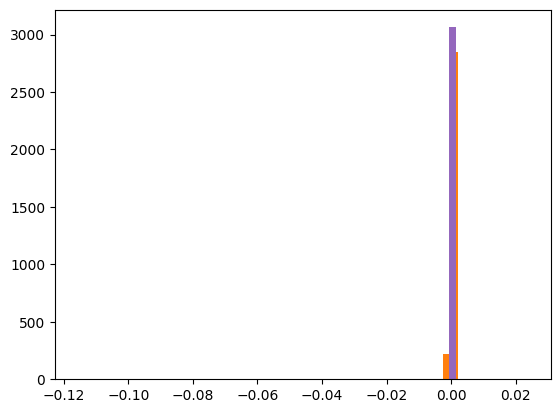

In [50]:
# hist the first 5 neurons
import matplotlib.pyplot as plt
for x in range(5):
    val = Sparse_nonlinear.linear.weight[:, x]
    plt.hist(val.detach().cpu().numpy(), bins=50)
plt.show()

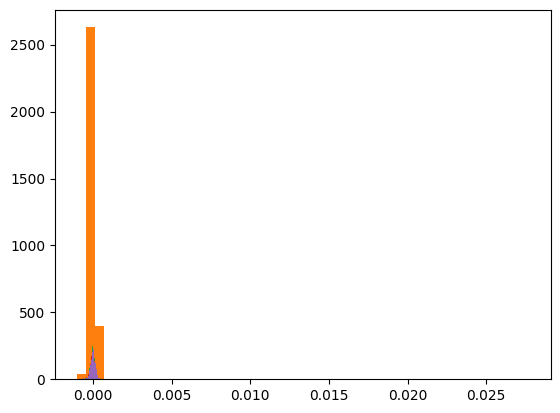

In [51]:
# hist the first 5 neurons
import matplotlib.pyplot as plt
for x in range(5):
    val = Sparse_nonlinear.linear.weight[x, :]
    plt.hist(val.detach().cpu().numpy(), bins=50)
plt.show()

In [37]:
list(Sparse_nonlinear.parameters())

[Parameter containing:
 tensor([[ 0.0124, -0.0044, -0.0002,  ..., -0.0062, -0.0021,  0.0138],
         [ 0.0145, -0.0066, -0.0114,  ...,  0.0170,  0.0121, -0.0112],
         [-0.0014,  0.0121, -0.0046,  ..., -0.0161,  0.0043, -0.0040],
         ...,
         [-0.0075,  0.0023,  0.0118,  ..., -0.0031, -0.0092, -0.0004],
         [-0.0063,  0.0080,  0.0002,  ..., -0.0180, -0.0156,  0.0083],
         [ 0.0041,  0.0157, -0.0164,  ...,  0.0036,  0.0057, -0.0050]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([ 0.0098, -0.0107,  0.0123,  ...,  0.0170,  0.0130,  0.0111],
        device='cuda:0', requires_grad=True)]

In [ ]:
Sparse_nonlinear.linear.weight.shape

In [ ]:
dictionary_activations[0].count_nonzero(dim=-1).float().mean()